<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matdmiller/blog/blob/main/posts/2023-06-10_transformers/notebook.ipynb)<br><br>
In this blog we're going to walk through creating and training a transformer from scratch. We'll go through each foundational element step by step and explain what is happening along the way. This blog is written in a Jupyter notebook which you can [download](https://github.com/matdmiller/blog/blob/main/posts/2023-06-10_transformers/notebook.ipynb) and use to run the code yourself as you follow along. Running the code as you follow along and changing it to see how the output changes will help you learn the concepts better than reading alone. While this is a lengthy topic, please don't be too alarmed with the length of the notebook or the amount of code. Most of it is copied from previous cells as we build up the transformer. Rather than just showing the code that was changed which would have shortened things up considerably, I chose to copy all required code down to the next cell to allow this entire notebook to be run from top to bottom. This should make it easier to run as well as allow you to experiment with each new concept as we go.

I'll be closely following [Andrej Karpathy's YouTube video 'Let's build GPT: from scratch, in code, spelled out.'](https://www.youtube.com/watch?v=kCc8FmEb1nY). We'll be heavily referencing the [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper as we go. If you would rather you can download the final version of the code from [Andrej's repo](https://github.com/karpathy/ng-video-lecture). The dataset we'll be using for this can downloaded [here](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt). You may also find referencing Andrej's [nanoGPT](https://github.com/karpathy/nanoGPT) repo helpful as well.


NOTE by frank morales January 23rd, 2024: THE ORIGINAL AUTHOR PUBLISHED HERE:
https://blog.matdmiller.com/posts/2023-06-10_transformers/notebook.html


# Getting started

To get started we'll first download the mini shakespeare dataset.

In [ ]:
#| output: true
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-01-21 06:30:57--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

input.txt.2         100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2024-01-21 06:30:57 (31.3 MB/s) - ‘input.txt.2’ saved [1115394/1115394]



Let's open it up and take a peek at what's inside.

In [ ]:
#| output: true
with open('input.txt') as f:
    text = f.read()
print('Length of input.txt (characters):',len(text))
print('First 500 characters:',text[:500])

Length of input.txt (characters): 1115394
First 500 characters: First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


# Tokenization

Now that we have our dataset the first thing we need to do is break it down into tokens which will be fed into the model. This is known as tokenization. There are various techniques for tokenization, `sub-word` being used in most of the more modern LLM's. Because our dataset is small for this toy problem, we are instead going to tokenize by each individual character. This makes tokenzation much simpler to implement and will also significantly reduce the number of unique tokens. The first thing we need to do is to go through the dataset and get a list of all unique characters or tokens which is known as the vocab.

In [ ]:
#| output: true
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
print('Vocab Size:',vocab_size)
print('Vocab:',vocab)

Vocab Size: 65
Vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


The neural networks are unable to take in characters directly. We must first convert the tokens to integers, which in our case means converting each individual character into integers. Those integers will then be used to index into the set of token embeddings. Token embeddings are learned vectors that represent each token that will be passed into the model. Let's create our character to index (integer) mapping.

In [ ]:
#| output: true
char2idx = {char:idx for idx,char in enumerate(vocab)}
idx2char = {idx:char for char,idx in char2idx.items()}
encode = lambda x: [char2idx[char] for char in x]
decode = lambda idxs: ''.join([idx2char[idx] for idx in idxs])
print('Character to index:',char2idx)
print('Index to character:,',idx2char)
print('Tokenization of `Hello World!`:',encode('Hello World!'))
print('String for token sequence `[20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42, 2]`:',decode([20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42, 2]))

Character to index: {'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
Index to character:, {0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43:

Now that we have our tokenizer we can go through and tokenize the dataset. This step may sometimes be done on the fly during training and inference instead of ahead of time with large datasets, but for our small dataset we can easily and quickly do this without significant memory utilization.

We are going to import pytorch and create a tensor for our encoded dataset. Pytorch is the library we'll be using to create and train the model.

In [ ]:
#| output: true
import torch
encoded_text = torch.tensor(encode(text))
print('Encoded Text shape:',encoded_text.shape, 'Encoded Text Dtype:', encoded_text.dtype)
encoded_text

Encoded Text shape: torch.Size([1115394]) Encoded Text Dtype: torch.int64


tensor([18, 47, 56,  ..., 45,  8,  0])

Now that we have the encoded text, we need to split it into a training and validation set. Creating a validation set will allow us to test the performance of our model after each epoch, or at an another interval of our choosing, to ensure that it's training correctly or improving over time. A typical split between training and validation is 90/10 which is what we'll use.

In [ ]:
#| output: true
train_split_pct = 0.9
train_split_idx = int(len(encoded_text)*train_split_pct)
train_split_idx

1003854

In [ ]:
#| output: true
train_data = encoded_text[:train_split_idx]
valid_data = encoded_text[train_split_idx:]
print('Train data length:',len(train_data),'Valid data length:',len(valid_data),
      'Train percentage:',len(train_data)/len(encoded_text))

Train data length: 1003854 Valid data length: 111540 Train percentage: 0.8999994620734916


Next we need to choose our context length. The context lenth is the maximum length of the sequence used when training the transformer. This is sometimes also referred to as the block size, which is how Andrej refers to it. When the transformer is trained, it is trained on each combination of tokens up to the maximum context length. For example if the context length was 5 the transformer would be trained on (0,1), (0,1,2), (0,1,2,3), and (0,1,2,3,4). Let's look at a more concrete example in code.

In [ ]:
#| output: true
context_length = 8
for i in range(context_length):
    x,y = train_data[:i+1], train_data[i+1]
    print('idx:',i,'x:',x,'y:',y,' | decoded version: x:',decode(x.tolist()),'y:',decode(y[None].tolist()))

idx: 0 x: tensor([18]) y: tensor(47)  | decoded version: x: F y: i
idx: 1 x: tensor([18, 47]) y: tensor(56)  | decoded version: x: Fi y: r
idx: 2 x: tensor([18, 47, 56]) y: tensor(57)  | decoded version: x: Fir y: s
idx: 3 x: tensor([18, 47, 56, 57]) y: tensor(58)  | decoded version: x: Firs y: t
idx: 4 x: tensor([18, 47, 56, 57, 58]) y: tensor(1)  | decoded version: x: First y:  
idx: 5 x: tensor([18, 47, 56, 57, 58,  1]) y: tensor(15)  | decoded version: x: First  y: C
idx: 6 x: tensor([18, 47, 56, 57, 58,  1, 15]) y: tensor(47)  | decoded version: x: First C y: i
idx: 7 x: tensor([18, 47, 56, 57, 58,  1, 15, 47]) y: tensor(58)  | decoded version: x: First Ci y: t


In [ ]:
#| output: true
TORCH_SEED = 1337 #Setting a manual torch seed for reproducable results
torch.manual_seed(TORCH_SEED) #Used to compare against @karpathy's lecture
context_length = 8 #Maximum number of tokens used in each training sequence
batch_size = 4 #number of batches that will be trained in parallel.

# Data Loader

Now we'll implement a function to get a batch of data from our training and validation datasets. We'll specify which dataset to pull from as a parameter and return the inputs and targets which we're naming x and y respectively. We'll go ahead and print out everything through the process so you can see what's going on.

In [ ]:
#| output: true
def get_batch(train_valid):
    data = train_data if train_valid == 'train' else valid_data
    data_len = len(data)
    start_idxs = torch.randint(high=len(data) - context_length, size=(batch_size,)) #tensor([ 76049, 234249, 934904, 560986])
    # print('start_idxs:',start_idxs)
    x = torch.stack([data[i:i+context_length] for i in start_idxs])
    y = torch.stack([data[i+1:i+context_length+1] for i in start_idxs])
    return x,y
xb, yb = get_batch('train')
print('inputs:')
print('shape:',xb.shape)
print(xb)
print('targets:')
print('shape:',yb.shape)
print(yb,'\n-----------------------------------------------')
for batch_idx in range(batch_size):
    for sequence_idx in range(context_length):
        context = xb[batch_idx,:sequence_idx+1]
        target = yb[batch_idx,sequence_idx]
        print(f"Given input context ({context.tolist()}) the target is: {target}")

inputs:
shape: torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
shape: torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]]) 
-----------------------------------------------
Given input context ([24]) the target is: 43
Given input context ([24, 43]) the target is: 58
Given input context ([24, 43, 58]) the target is: 5
Given input context ([24, 43, 58, 5]) the target is: 57
Given input context ([24, 43, 58, 5, 57]) the target is: 1
Given input context ([24, 43, 58, 5, 57, 1]) the target is: 46
Given input context ([24, 43, 58, 5, 57, 1, 46]) the target is: 43
Given input context ([24, 43, 58, 5, 57, 1, 46, 43]) the target is: 39
Given input context ([44]) the target is: 53
Given input context ([44, 53]) the ta

You may have noticed that the inputs and targets appear to be the same, just shifted by one, which is correct. To help give you a better understanding on how the inputs and targets are combined, we printed out every combination of input and target. As you can see each input sequence is really multiple sequences starting with the first token in the sequence as the input and the second token in the sequence being the target all the way to the full input sequence being the input and the subsequent character being the target.

# Bigram Model

Before jumping into using a transformer we'll start with a bigram model. A bigram model predicts the probability of one token following another. For example given the token for the letter 'a' what is the probability of each token in the vocab will be the next token.

In [ ]:
#| output: true
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
#| output: true
torch.manual_seed(TORCH_SEED)
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        #Each token reads off the logits (~probabilities) from the subsequent token from the lookup table
        self.token_embedding_table = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.vocab_size)

    def forward(self, idx, targets):
        #Both idx and targets are (B,T) Batch x Time array of integers
        logits = self.token_embedding_table(idx) #(B,T,C) Batch, Time, Channel
        return logits

bigram_model = BigramLanguageModel(vocab_size=vocab_size)
out = bigram_model(xb, yb)
print('Bigram Model Output Shapes out:',out.shape,'xb:',xb.shape,'yb:',yb.shape,'embeddings:',bigram_model.token_embedding_table)

Bigram Model Output Shapes out: torch.Size([4, 8, 65]) xb: torch.Size([4, 8]) yb: torch.Size([4, 8]) embeddings: Embedding(65, 65)


Now we'll add a loss function to the forward method. We will use the negative log likelihood, which is known in pytorch as the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html). To be able to use the cross entropy loss we'll need to reshape the output and targets to match the format that it expects. The model output should be a 2D tensor (B\*T x C) and targets should be a 1D tensor (B\*T). We need to squash the batch and time dimensions on the model output and the batch and time dimensions of the targets using the `.view` method.

In [ ]:
#| output: true
torch.manual_seed(TORCH_SEED)
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        #Each token reads off the logits from the subsequent token from the lookup table
        self.token_embedding_table = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.vocab_size)

    def forward(self, idx, targets):
        #Both idx and targets are (B,T) Batch x Time array of integers
        logits = self.token_embedding_table(idx) #(B,T,C) Batch, Time, Channel
        B,T,C = logits.shape
        logits_reshaped = logits.view(B*T,C)
        targets_reshaped = targets.view(B*T)
        loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        return logits, loss

bigram_model = BigramLanguageModel(vocab_size=vocab_size)
out,loss = bigram_model(xb, yb)
print('Bigram Model Output Shapes out:',out.shape,'xb:',xb.shape,'yb:',yb.shape)
print('The calculated loss is:',loss)

Bigram Model Output Shapes out: torch.Size([4, 8, 65]) xb: torch.Size([4, 8]) yb: torch.Size([4, 8])
The calculated loss is: tensor(4.8786, grad_fn=<NllLossBackward0>)


Now we're going to add a generate method to perform character generation from our model. Instead of explaining here what each generation step is doing, detailed code comments have been added before each step. There are also commented out `print` statements that you can uncomment and run to help you understand what's going on as well.<br>

One pytorch function you may not have seen before is [`torch.multinomial`](https://pytorch.org/docs/stable/generated/torch.multinomial.html). It returns `num_samples`, in our case 1, based on the weighted probability distribution of the predictions for each token.

In [ ]:
#| output: true
torch.manual_seed(TORCH_SEED)
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        #Each token reads off the logits from the subsequent token from the lookup table
        self.token_embedding_table = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.vocab_size)

    def forward(self, idx, targets=None):
        #Both idx and targets are (B,T) Batch x Time array of integers
        logits = self.token_embedding_table(idx) #(B,T,C) Batch, Time, Channel
        if targets is not None:
            B,T,C = logits.shape
            logits_reshaped = logits.view(B*T,C)
            targets_reshaped = targets.view(B*T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss=None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        #idx is (B,T) array of indicies in the current context
        for _ in range(max_new_tokens):
            #Get predictions - calling `forward`
            logits, loss = self(idx)
            #Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:,-1,:] #Becomes (B,C)
            # print('Shape of logits_last_timestep:',logits_last_timestep.shape) #confirming shape
            #Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1) #(B,C)
            # print('Shape of probs:', probs.shape) #confirming shape
            #Sample from the probs distribution.
            idx_next = torch.multinomial(input=probs, num_samples=1) #(B,1) Returns (B,idxs) where idxs are random integer indicies.
            # print('Shape of idx_next:',idx_next.shape,'and contents:',idx_next) #look at the shape and contents of idx_next
            #Append the sampled indexes idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1) #(B, T+1)
        return idx

bigram_model = BigramLanguageModel(vocab_size=vocab_size)
logits, loss = bigram_model(xb,yb)
print('Loss:',loss)
idx=torch.zeros((1,1), dtype=torch.long)#Creating a single batch with single time step with index of 0
#which is the `\n` new line char to be our starting point.
#Now let's generate a character sequence to see what it looks like.
print('100 Generated Tokens:',decode(bigram_model.generate(idx,max_new_tokens=100)[0].tolist()))


Loss: tensor(4.8786, grad_fn=<NllLossBackward0>)
100 Generated Tokens: 
Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


The output of this is totally nonsensical noise because the model is not trained.  Next we'll get set up to train the model.

The first thing we'll do is create an optimizer:

In [ ]:
#| output: true
optimizer = torch.optim.Adam(params=bigram_model.parameters(), lr=1e-3)

For more info on the `Adam` optimizer or optimizers in general, check out this great [video](https://youtu.be/nlVOG2Nzc3k?si=Lj7UH14PG7u48F4M&t=995) from fast.ai. <br>
<br>
Next, we'll create a basic training loop.

In [ ]:
#| output: true
batch_size = 32
for steps in range(100):
    #Sample a batch of data
    xb, yb = get_batch('train')

    #Evaluate the loss
    logits, loss = bigram_model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Loss:',round(loss.item(),3), end=' ')


Loss: 4.704 Loss: 4.721 Loss: 4.653 Loss: 4.706 Loss: 4.781 Loss: 4.751 Loss: 4.84 Loss: 4.668 Loss: 4.744 Loss: 4.774 Loss: 4.691 Loss: 4.789 Loss: 4.618 Loss: 4.651 Loss: 4.887 Loss: 4.704 Loss: 4.758 Loss: 4.655 Loss: 4.709 Loss: 4.675 Loss: 4.761 Loss: 4.79 Loss: 4.654 Loss: 4.662 Loss: 4.673 Loss: 4.666 Loss: 4.73 Loss: 4.756 Loss: 4.712 Loss: 4.746 Loss: 4.727 Loss: 4.735 Loss: 4.778 Loss: 4.644 Loss: 4.666 Loss: 4.798 Loss: 4.718 Loss: 4.684 Loss: 4.819 Loss: 4.614 Loss: 4.574 Loss: 4.561 Loss: 4.816 Loss: 4.607 Loss: 4.62 Loss: 4.726 Loss: 4.651 Loss: 4.595 Loss: 4.721 Loss: 4.7 Loss: 4.673 Loss: 4.729 Loss: 4.662 Loss: 4.617 Loss: 4.6 Loss: 4.654 Loss: 4.717 Loss: 4.693 Loss: 4.668 Loss: 4.656 Loss: 4.656 Loss: 4.755 Loss: 4.724 Loss: 4.618 Loss: 4.705 Loss: 4.753 Loss: 4.57 Loss: 4.549 Loss: 4.572 Loss: 4.57 Loss: 4.599 Loss: 4.549 Loss: 4.592 Loss: 4.661 Loss: 4.624 Loss: 4.743 Loss: 4.645 Loss: 4.644 Loss: 4.581 Loss: 4.584 Loss: 4.723 Loss: 4.67 Loss: 4.631 Loss: 4.556 Los

As you can see the loss is improving, but only a little bit.  Next we'll train for longer.

In [ ]:
#| output: true
batch_size = 32
for steps in range(1000):
    #Sample a batch of data
    xb, yb = get_batch('train')

    #Evaluate the loss
    logits, loss = bigram_model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if steps % 100 == 0: print('Step:',steps,'Loss:',round(loss.item(),3), end=' ')


Step: 0 Loss: 4.66 Step: 100 Loss: 4.472 Step: 200 Loss: 4.323 Step: 300 Loss: 4.256 Step: 400 Loss: 4.245 Step: 500 Loss: 4.166 Step: 600 Loss: 4.049 Step: 700 Loss: 4.097 Step: 800 Loss: 3.75 Step: 900 Loss: 3.707 

The loss seems to be steadily decreasing. Let's train for a lot longer and then see what the results look like.

In [ ]:
#| output: true
batch_size = 32
for steps in range(10000):
    #Sample a batch of data
    xb, yb = get_batch('train')

    #Evaluate the loss
    logits, loss = bigram_model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if steps % 100 == 0: print('Step:',steps,'Loss:',round(loss.item(),3), end=' ')


Step: 0 Loss: 3.716 Step: 100 Loss: 3.638 Step: 200 Loss: 3.425 Step: 300 Loss: 3.433 Step: 400 Loss: 3.427 Step: 500 Loss: 3.304 Step: 600 Loss: 3.286 Step: 700 Loss: 3.19 Step: 800 Loss: 3.203 Step: 900 Loss: 3.139 Step: 1000 Loss: 3.003 Step: 1100 Loss: 3.06 Step: 1200 Loss: 2.959 Step: 1300 Loss: 2.982 Step: 1400 Loss: 2.92 Step: 1500 Loss: 2.841 Step: 1600 Loss: 2.89 Step: 1700 Loss: 2.975 Step: 1800 Loss: 2.808 Step: 1900 Loss: 2.777 Step: 2000 Loss: 2.747 Step: 2100 Loss: 2.685 Step: 2200 Loss: 2.68 Step: 2300 Loss: 2.687 Step: 2400 Loss: 2.81 Step: 2500 Loss: 2.692 Step: 2600 Loss: 2.665 Step: 2700 Loss: 2.631 Step: 2800 Loss: 2.752 Step: 2900 Loss: 2.581 Step: 3000 Loss: 2.629 Step: 3100 Loss: 2.625 Step: 3200 Loss: 2.548 Step: 3300 Loss: 2.582 Step: 3400 Loss: 2.603 Step: 3500 Loss: 2.618 Step: 3600 Loss: 2.572 Step: 3700 Loss: 2.511 Step: 3800 Loss: 2.607 Step: 3900 Loss: 2.508 Step: 4000 Loss: 2.572 Step: 4100 Loss: 2.494 Step: 4200 Loss: 2.523 Step: 4300 Loss: 2.483 Step: 

Ok, it looks like the loss has stopped improving. Now we'll see what the output looks like.

In [ ]:
#| output: true
print(decode(bigram_model.generate(torch.zeros((1,1), dtype=torch.long),max_new_tokens=500)[0].tolist()))



weangond
OMave wap

I RO:
Banleenoalit-blt
INRon

UM: nd kngonesll;
O: pa heore 'ga llis?-sur inidind;
t me rthay n thavee
Sw s serer Fofow.
Houspathe t:
Mind fit.
DUKINoceamy hun.
CKIUShorst onre t ache bar, simed?
And me theluse BHENurind hesto f w m CK:
YCESI fatass mbre lious ave
Wer'dor' wod y:

Henkns ges wise we me y to elil'doug p in t her spalisusin t wndalu?Y ber lishms vekeang-lumod n odas ine a! thayayor hannd t; frat.
OLArZAUSum,
s I f pin hondecharvyouke helldid t we ke,
HOShe lll


The results are still not great, but they're looking more reasonable than they were at first. There are now things that look like words and sentences. Keep in mind this model is predicting the next token or character solely based on the previous token so it doesn't really have a lot to go by.  Learning about the dataset, training loop and getting a basline with a simplistic model is always a good first step in any AI project. This allows you to see if further improvements are helping as well as gives you a baseline to compare your model with.

Before moving on, let's do a quick loop through the validation set to see what its loss is so we can use it for comparison in the future.

In [ ]:
#| output: true
print('Length of Validation Set: ',len(valid_data),'Shape of Batch:',xb.shape,'~Steps needed to cover validation set:',
      len(valid_data)//batch_size//8)

Length of Validation Set:  111540 Shape of Batch: torch.Size([32, 8]) ~Steps needed to cover validation set: 435


In [ ]:
#| output: true
batch_size = 32
torch.manual_seed(TORCH_SEED)
losses = []
for steps in range(len(valid_data)//batch_size//8):
    #Sample a batch of data
    xb, yb = get_batch('valid')
    with torch.no_grad():
    #Evaluate the loss
        logits, loss = bigram_model(xb, yb)
        losses.append(loss)

    if steps % 10 == 0: print('Step:',steps,'Loss:',round(loss.item(),3), end=' ')
print('\n\nFinal Validation Loss:',torch.stack(losses,dim=0).mean())

Step: 0 Loss: 2.441 Step: 10 Loss: 2.524 Step: 20 Loss: 2.545 Step: 30 Loss: 2.53 Step: 40 Loss: 2.397 Step: 50 Loss: 2.469 Step: 60 Loss: 2.563 Step: 70 Loss: 2.475 Step: 80 Loss: 2.621 Step: 90 Loss: 2.517 Step: 100 Loss: 2.536 Step: 110 Loss: 2.609 Step: 120 Loss: 2.492 Step: 130 Loss: 2.385 Step: 140 Loss: 2.473 Step: 150 Loss: 2.54 Step: 160 Loss: 2.53 Step: 170 Loss: 2.611 Step: 180 Loss: 2.504 Step: 190 Loss: 2.425 Step: 200 Loss: 2.454 Step: 210 Loss: 2.459 Step: 220 Loss: 2.539 Step: 230 Loss: 2.496 Step: 240 Loss: 2.392 Step: 250 Loss: 2.394 Step: 260 Loss: 2.439 Step: 270 Loss: 2.433 Step: 280 Loss: 2.509 Step: 290 Loss: 2.458 Step: 300 Loss: 2.452 Step: 310 Loss: 2.439 Step: 320 Loss: 2.593 Step: 330 Loss: 2.461 Step: 340 Loss: 2.348 Step: 350 Loss: 2.421 Step: 360 Loss: 2.455 Step: 370 Loss: 2.574 Step: 380 Loss: 2.47 Step: 390 Loss: 2.507 Step: 400 Loss: 2.404 Step: 410 Loss: 2.491 Step: 420 Loss: 2.365 Step: 430 Loss: 2.494 

Final Validation Loss: tensor(2.4817)


The final validation loss appears similar to the training loss which makes sense given how basic this model is. Now we'll move on to creating a transformer and see how it does compared to the our basic bigram model.

Clearing out variables from above to start fresh.

In [ ]:
%reset -f

# Code re-write in preparation for Transformers

We're going to re-write some of our code from before to clean things up before jumping into building the transformer.

In [ ]:
#| output: true
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
#| output: true
#Hyperparameters
batch_size = 32 #Number of token chunks per batch
context_length = 8 #Length of the token chunks. Andrej called this block size
learning_rate = 1e-2
max_iters = 3000 #Number of training iterations or steps. Typically we specify the number of epochs but since we're randomly sampling...
#...from the training set we don't necessarily know exactly when we've seen all the text from the training set so we'll use this instead.
eval_interval = 300 #Number of steps between evaluating the validation set to see how our validation loss is doing.
eval_iters = 200 #Number of steps to do on the validation set per each interval. We do more than 1 to get a more accurate overall valid loss
device = 'cuda' if torch.cuda.is_available() else 'cpu' #Instead of using the cpu, we'll use the GPU if it's availble.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [ ]:
#| output: true
with open('input.txt','r',encoding='utf-8') as f:
    text = f.read()
print('Length of text:',len(text))

Length of text: 1115394


In [ ]:
#| output: true
vocab = sorted(list(set(text))) #Called chars in the video, but vocab is a more generic term. Both are correct.
vocab_size = len(vocab)
print('Vocab size:',vocab_size,',Vocab:',vocab)

Vocab size: 65 ,Vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Create the token mapping functions

In [ ]:
#| output: true
char2idx = {char:idx for idx,char in enumerate(vocab)}
idx2char = {idx:char for char,idx in char2idx.items()}
encode = lambda x: [char2idx[char] for char in x]
decode = lambda idxs: ''.join([idx2char[idx] for idx in idxs])
print('Character to index:',char2idx)
print('Index to character:,',idx2char)
print('Tokenization of `Hello World!`:',encode('Hello World!'))
print('String for token sequence `[20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42, 2]`:',decode([20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42, 2]))

Character to index: {'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
Index to character:, {0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43:

Next we'll tokenize our dataset.

In [ ]:
#| output: true
tokenized_text = torch.tensor(encode(text),dtype=torch.long)
tokenized_text[:100]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])

And split it into training and validation sets

In [ ]:
#| output: true
#The first 90% of data will be the training set, the rest will be validation set.
train_test_split_idx = int(len(tokenized_text) * 0.9)
print('Train test split index:',train_test_split_idx)
train_data = tokenized_text[:train_test_split_idx]
valid_data = tokenized_text[train_test_split_idx:]
print('Lenth of training data:',len(train_data),'Length of validation data:',len(valid_data))

Train test split index: 1003854
Lenth of training data: 1003854 Length of validation data: 111540


Next we'll set up a basic data loader to get data in batches

In [ ]:
#| output: true
def get_batch(split:str, batch_size:int=batch_size, context_length:int=context_length):
    #Function to get a batch of data from the train or valid dataset
    data = train_data if split == 'train' else valid_data
    idxs = torch.randint(low=0, high=len(data)-context_length, size=(batch_size,))
    x = torch.stack([data[idx:idx+context_length] for idx in idxs])
    y = torch.stack([data[idx+1:idx+context_length+1] for idx in idxs])
    x,y = x.to(device), y.to(device) #Send data to the GPU if available
    return x,y
bx,by = get_batch('train')
print('Batch of x shape:',bx.shape,'Batch of y shape:',by.shape,' dimension are [batch x context_length]')
del bx, by

Batch of x shape: torch.Size([32, 8]) Batch of y shape: torch.Size([32, 8])  dimension are [batch x context_length]


Next we'll create a function to estimate the loss for our model. Typically this is calculated against the training set for each training step and at the end of each epoch for the validation set but to keep things simple we'll just calculate it when called based on the number of steps specified as `eval_iters` and take the mean for the training and validation sets respectively. This also helps smooth out the loss values.

In [ ]:
#| output: true
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train','valid']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x_batch, y_batch = get_batch(split)
            logits, loss = model(x_batch, y_batch)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

We're going to keep the model framework from the Bigram model and add in the transfomer parts shortly. For now, we just need to make sure that our updated code still works.

In [ ]:
#| output: true
torch.manual_seed(TORCH_SEED)
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        #Each token reads off the logits from the subsequent token from the lookup table
        self.token_embedding_table = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.vocab_size)

    def forward(self, idx, targets=None):
        #Both idx and targets are (B,T) Batch x Time array of integers
        logits = self.token_embedding_table(idx) #(B,T,C) Batch, Time, Channel
        if targets is not None:
            B,T,C = logits.shape
            logits_reshaped = logits.view(B*T,C)
            targets_reshaped = targets.view(B*T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss=None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        #idx is (B,T) array of indicies in the current context
        for _ in range(max_new_tokens):
            #Get predictions
            logits, loss = self(idx)
            #Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:,-1,:] #Becomes (B,C)
            # print('Shape of logits_last_timestep:',logits_last_timestep.shape) #confirming shape
            #Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1) #(B,C)
            # print('Shape of probs:', probs.shape) #confirming shape
            #Sample from the probs distribution.
            idx_next = torch.multinomial(input=probs, num_samples=1) #(B,1) Returns (B,idxs) where idxs are random integer indicies.
            # print('Shape of idx_next:',idx_next.shape,'and contents:',idx_next) #look at the shape and contents of idx_next
            #Append the sampled indexes idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1) #(B, T+1)
        return idx

model = BigramLanguageModel(vocab_size=vocab_size)
model = model.to(device)

In [ ]:
#| output: true
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)

In [ ]:
#| output: true
for step in range(max_iters):

    if step % eval_iters == 0 or step == max_iters-1:
        losses = estimate_loss()
        print('Step:',step,'Training Loss:',losses['train'],'Validation Loss:',losses['valid'])

    xb,yb = get_batch('train')
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context,max_new_tokens=500)[0].tolist()))

Step: 0 Training Loss: tensor(4.7305) Validation Loss: tensor(4.7241)
Step: 200 Training Loss: tensor(3.1193) Validation Loss: tensor(3.1313)
Step: 400 Training Loss: tensor(2.6480) Validation Loss: tensor(2.6667)
Step: 600 Training Loss: tensor(2.5434) Validation Loss: tensor(2.5689)
Step: 800 Training Loss: tensor(2.5155) Validation Loss: tensor(2.5248)
Step: 1000 Training Loss: tensor(2.5008) Validation Loss: tensor(2.5115)
Step: 1200 Training Loss: tensor(2.4787) Validation Loss: tensor(2.4992)
Step: 1400 Training Loss: tensor(2.4747) Validation Loss: tensor(2.4983)
Step: 1600 Training Loss: tensor(2.4739) Validation Loss: tensor(2.4940)
Step: 1800 Training Loss: tensor(2.4734) Validation Loss: tensor(2.4947)
Step: 2000 Training Loss: tensor(2.4608) Validation Loss: tensor(2.4934)
Step: 2200 Training Loss: tensor(2.4664) Validation Loss: tensor(2.4994)
Step: 2400 Training Loss: tensor(2.4763) Validation Loss: tensor(2.4762)
Step: 2600 Training Loss: tensor(2.4708) Validation Loss: 

# Previous Token Averages - Building Intuition for Self Attention

Attention was the key discovery that enabled the transformer architecture. The idea is that each token should be able to communicate with or look at each previous token in the sequence but not future tokens. For example given token number 4 in a sequence of 8 tokens, token 4 should be able to access token 1, 2 and 3, but not tokens 5 through 8. We will demonstrate this with a for loop implementation to cement the concept and then show the equivalent calculation using matrix multiplication which is how transformers are implemented in real life because the matrix multiplication is orders of magnitudes faster than basic nested `for` loops.

In [ ]:
#| output: true
torch.manual_seed(TORCH_SEED)
B,T,C = 4, 8, 2 #Batch, Time, Channel - Time is each token (char) in the sequence and channel is the embedding dimension
x = torch.randn((B,T,C))
x.shape

torch.Size([4, 8, 2])

In this example we're going to take the average of the previous tokens, just for illustration purposes, not because the average is a good way to represent the data from previous tokens.

In [ ]:
#| output: true
x_bag_of_words = torch.zeros((B,T,C))
for batch_idx in range(B):
    for token_idx in range(T):
        x_previous = x[batch_idx,:token_idx+1] # (T,C)
        x_bag_of_words[batch_idx,token_idx] = torch.mean(x_previous, dim=0)
print('Testing if mean is being calculated correctly. Should be True, True, False:',torch.allclose(x[0,0],x_bag_of_words[0,0]),
      torch.allclose(x[0,:2].mean(dim=0),x_bag_of_words[0,1]), torch.allclose(x[0,0],x_bag_of_words[0,1]))

Testing if mean is being calculated correctly. Should be True, True, False: True True False


Each item in x_bag_of_words should be the cumulative mean of all values in x up to that index. For index 0 you can see the results are the same and for index 1 you can quickly recognize that in fact `x_bag_of_words` is the cumulative mean of x at index 0 and 1.

In [ ]:
#| output: true
x[0],x_bag_of_words[0]

(tensor([[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))

Next, we'll delve into the basic operations of matrix multiplication. Specifically, we're focusing on the multiplication of two matrices, denoted as `a` and `b`. In Python, matrix multiplication is symbolized using the `@` operator. The process of matrix multiplication entails multiplying the rows of the first matrix (in this case, matrix `a`) by the columns of the second matrix (here, matrix `b`) when dealing with 2-dimensional matrices. After multiplying, the results are summed up to give the final outcome.

Let's consider a practical example to illustrate this: calculating the value of `c[0,0]`. To achieve this, we need to multiply the first row of matrix `a` with the first column of matrix `b`, and then sum the results.

In mathematical terms, it looks like this: `(a[0,0] * b[0,0]) + (a[0,1] * b[1,0]) + (a[0,2] * b[2,0])`. Using the example values below, the equation becomes `(1 * 1) + (2 * 3) + (3 * 5) = 22`.

To enhance your understanding and intuition of matrix multiplication, I recommend the website http://matrixmultiplication.xyz/. It provides interactive visualizations of the matrix multiplication process, which can help you to understand the concept.

In [ ]:
#| output: true
a = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
b = torch.tensor([[1,2],[3,4],[5,6]])
c = a @ b
print('a =\n',a,'\n-----')
print('b =\n',b,'\n-----')
print('c = a @ b =\n',c,'\n-----')

a =
 tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]) 
-----
b =
 tensor([[1, 2],
        [3, 4],
        [5, 6]]) 
-----
c = a @ b =
 tensor([[ 22,  28],
        [ 49,  64],
        [ 76, 100]]) 
-----


The next function we need to learn about is the pytorch [`tril`](https://pytorch.org/docs/stable/generated/torch.tril.html) function. It zeros out the upper right portion of a matrix.  Let's look at a few quick examples to help visualize the concept.<br>

First let's apply it to a 3x3 matrix of ones.

In [ ]:
#| output: true
torch.tril(torch.ones(3,3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

Next we'll apply it to a 4x4 matrix of random numbers just to show this can be used with numbers other than ones.

In [ ]:
#| output: true
torch.tril(torch.randn((4,4)))

tensor([[-0.8345,  0.0000,  0.0000,  0.0000],
        [-0.4970,  0.4658,  0.0000,  0.0000],
        [ 2.0089, -0.5370,  0.2228,  0.0000],
        [-1.4267,  0.9059,  0.1446,  0.2280]])

Now let's see what happens when we use the tril function with our matrix multiply from before:

In [ ]:
#| output: true
a = torch.tril(torch.tensor([[1,2,3],[4,5,6],[7,8,9]]))
b = torch.tensor([[1,2],[3,4],[5,6]])
c = a @ b
print('a =\n',a,'\n-----')
print('b =\n',b,'\n-----')
print('c = a @ b =\n',c,'\n-----')

a =
 tensor([[1, 0, 0],
        [4, 5, 0],
        [7, 8, 9]]) 
-----
b =
 tensor([[1, 2],
        [3, 4],
        [5, 6]]) 
-----
c = a @ b =
 tensor([[  1,   2],
        [ 19,  28],
        [ 76, 100]]) 
-----


Next we'll switch out our first matrix with a matrix of ones instead.

In [ ]:
#| output: true
a = torch.tril(torch.ones((3,3),dtype=torch.long))
b = torch.tensor([[1,2],[3,4],[5,6]])
c = a @ b
print('a =\n',a,'\n-----')
print('b =\n',b,'\n-----')
print('c = a @ b =\n',c,'\n-----')

a =
 tensor([[1, 0, 0],
        [1, 1, 0],
        [1, 1, 1]]) 
-----
b =
 tensor([[1, 2],
        [3, 4],
        [5, 6]]) 
-----
c = a @ b =
 tensor([[ 1,  2],
        [ 4,  6],
        [ 9, 12]]) 
-----


Let's examine the first row in `c` which contains the values `[1, 2]`. Notice that it is the cumulative sum of the first row of `b` and rows 2 and 3 in `b` are effectively masked out. Row 2 in `c` is the cumulative sum of rows 1 and 2 from `b` and so on. Hopefully you can see that, like in our `for` loop, we are effectively cumulatively summing up `b`.

Now we're going to reproduce our `for` loop results using matrix multiplication.

In [ ]:
#| output: true
x.shape, x_bag_of_words.shape

(torch.Size([4, 8, 2]), torch.Size([4, 8, 2]))

In [ ]:
#| output: true
mask = torch.tril(torch.ones((1,8,8),dtype=torch.float))
a = mask
b = x
c = a @ b
print('Shape of c:',c.shape)
c

Shape of c: torch.Size([4, 8, 2])


tensor([[[ 0.1808, -0.0700],
         [-0.1789, -0.9852],
         [ 0.4469, -0.9597],
         [ 1.4014, -0.8953],
         [ 1.7626,  0.2725],
         [ 0.4127, -0.2376],
         [ 0.6486, -0.4774],
         [-0.2725,  1.0659]],

        [[ 1.3488, -0.1396],
         [ 1.6346,  0.8255],
         [-0.4025,  1.3186],
         [ 1.0845,  1.9096],
         [ 1.2105,  0.3470],
         [ 0.0504,  0.0121],
         [ 0.4982, -0.7895],
         [ 2.0218,  1.7191]],

        [[-0.6631, -0.2513],
         [ 0.3470, -0.1297],
         [ 0.5054,  1.0043],
         [-0.6484,  0.7059],
         [-1.1560, -0.2180],
         [-0.6093, -1.7128],
         [-1.8150, -1.1410],
         [-2.4123, -1.8347]],

        [[ 1.6455, -0.8030],
         [ 2.9969, -1.0789],
         [ 1.4861,  1.0259],
         [ 4.2491, -0.7207],
         [ 5.7007, -2.2310],
         [ 6.5218, -2.4425],
         [ 7.3007, -0.9092],
         [ 8.9105, -1.3124]]])

Comparing to `x_bag_of_words`, we can see the values are different.  This is because we have calculated the cumulative sum, but not the mean. This is why at each batch's idx 0 the answer is correct as it's only summing 1 item and the sum divided by 1 is both the mean and sum.

In [ ]:
#| output: true
x_bag_of_words

tensor([[[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]],

        [[ 1.3488, -0.1396],
         [ 0.8173,  0.4127],
         [-0.1342,  0.4395],
         [ 0.2711,  0.4774],
         [ 0.2421,  0.0694],
         [ 0.0084,  0.0020],
         [ 0.0712, -0.1128],
         [ 0.2527,  0.2149]],

        [[-0.6631, -0.2513],
         [ 0.1735, -0.0649],
         [ 0.1685,  0.3348],
         [-0.1621,  0.1765],
         [-0.2312, -0.0436],
         [-0.1015, -0.2855],
         [-0.2593, -0.1630],
         [-0.3015, -0.2293]],

        [[ 1.6455, -0.8030],
         [ 1.4985, -0.5395],
         [ 0.4954,  0.3420],
         [ 1.0623, -0.1802],
         [ 1.1401, -0.4462],
         [ 1.0870, -0.4071],
         [ 1.0430, -0.1299],
         [ 1.1138, -0.1641]]])

Now we'll divide by the number of items that were summed to get the mean. Just like before we're going to use a matrix operation to keep things fast. First we'll create the matrix:

In [ ]:
#| output: true
num_toks_summed = torch.tensor(list(zip(list(range(1,9)),list(range(1,9)))))
num_toks_summed

tensor([[1, 1],
        [2, 2],
        [3, 3],
        [4, 4],
        [5, 5],
        [6, 6],
        [7, 7],
        [8, 8]])

And now we'll divide our cumulative sum by the number of items summed.

In [ ]:
#| output: true
c2 = c/num_toks_summed
c2

tensor([[[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]],

        [[ 1.3488, -0.1396],
         [ 0.8173,  0.4127],
         [-0.1342,  0.4395],
         [ 0.2711,  0.4774],
         [ 0.2421,  0.0694],
         [ 0.0084,  0.0020],
         [ 0.0712, -0.1128],
         [ 0.2527,  0.2149]],

        [[-0.6631, -0.2513],
         [ 0.1735, -0.0649],
         [ 0.1685,  0.3348],
         [-0.1621,  0.1765],
         [-0.2312, -0.0436],
         [-0.1015, -0.2855],
         [-0.2593, -0.1630],
         [-0.3015, -0.2293]],

        [[ 1.6455, -0.8030],
         [ 1.4985, -0.5395],
         [ 0.4954,  0.3420],
         [ 1.0623, -0.1802],
         [ 1.1401, -0.4462],
         [ 1.0870, -0.4071],
         [ 1.0430, -0.1299],
         [ 1.1138, -0.1641]]])

And check whether it matches our previously calculated bow, which it does.

In [ ]:
#| output: true
torch.allclose(x_bag_of_words, c2)

True

As an aside, let's look at how long the x_bag_of_words took to calculate via a for loop vs our matrix version. As the number of calculations is tiny in this case, we're going to increase the complexity so you can more easily see the time differences.<br>
First we'll do the for loop version:

In [ ]:
#| output: true
torch.manual_seed(TORCH_SEED)
# B,T,C = 4, 8, 2 #Batch, Time, Channel - Time is each token (char) in the sequence and channel is the embedding dimension
B,T,C = 256, 512, 64
x = torch.randn((B,T,C))
x.shape
x_bag_of_words = torch.zeros((B,T,C))

In [ ]:
%%timeit -n 2 -r 2
#| output: true
for batch_idx in range(B):
    for token_idx in range(T):
        x_previous = x[batch_idx,:token_idx+1] # (T,C)
        x_bag_of_words[batch_idx,token_idx] = torch.mean(x_previous, dim=0)
print('Testing if mean is being calculated correctly. Should be True, True, False:',torch.allclose(x[0,0],x_bag_of_words[0,0]),
      torch.allclose(x[0,:2].mean(dim=0),x_bag_of_words[0,1]), torch.allclose(x[0,0],x_bag_of_words[0,1]))

Testing if mean is being calculated correctly. Should be True, True, False: True True False
Testing if mean is being calculated correctly. Should be True, True, False: True True False
Testing if mean is being calculated correctly. Should be True, True, False: True True False
Testing if mean is being calculated correctly. Should be True, True, False: True True False
3.69 s ± 113 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


The for loop version on my PC took 4.3 seconds: `4.33 s ± 24.2 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)`. <br>
Now we'll test the matrix version:

In [ ]:
#| output: true
mask = torch.tril(torch.ones((1,T,T),dtype=torch.float))
num_toks_summed = torch.Tensor([[i+1]*C for i in range(T)])
a = mask
b = x

In [ ]:
%%timeit -n 2 -r 2
#| output: true
c = a @ b / num_toks_summed
# print('Shape of c:',c.shape)

158 ms ± 1.5 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


The matrix multiplication version on the other hand took 20 ms. `19.8 ms ± 872 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)`<br>
Now we'll confirm the results are the same

In [ ]:
#| output: true
c = a @ b / num_toks_summed

In [ ]:
#| output: true
torch.allclose(x_bag_of_words, c, atol=1e-5)

True

In [ ]:
#| output: true
4.33/(19.8/1000) # 4.33 seconds / 19.8 ms

218.68686868686868

As you can see the results were the same but the matrix multiplication version finished in ~20ms vs ~4.3s (numbers may vary between runs and machines) for the for loop version which is ~220x faster and that is running the matmul on the cpu instead of gpu which would speed it up even further.

Alternatively we can use Andrej's method which should be even more efficient because we're dividing the mask elements by the number of elements to be summed which is effectively moving the division by `num_toks_summed` out of our final timed calculation.

In [ ]:
#| output: true
mask = torch.tril(torch.ones((1,T,T),dtype=torch.float))
mask = mask / mask.sum(dim=2,keepdim=True)
a = mask
b = x

In [ ]:
%%timeit -n 2 -r 2
#| output: true
c = a @ b
# print('Shape of c:',c.shape)

133 ms ± 2.57 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


`20.7 ms ± 1.21 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)` In this case the numbers are very close. This could be influenced by a number of factors, but in general it's best to try and compute things once vs for each iteration if possible.

In [ ]:
#| output: true
c = a @ b

In [ ]:
#| output: true
torch.allclose(x_bag_of_words, c, atol=1e-5)

True

Now let's look at the 3rd version of calculating this using softmax. It should produce an identical result.

In [ ]:
#| output: true
mask = torch.tril(torch.ones((1,T,T),dtype=torch.float))
mask

tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [ ]:
#| output: true
mask2 = torch.zeros_like(mask).masked_fill(mask==0,float('-inf'))
mask2

tensor([[[0., -inf, -inf,  ..., -inf, -inf, -inf],
         [0., 0., -inf,  ..., -inf, -inf, -inf],
         [0., 0., 0.,  ..., -inf, -inf, -inf],
         ...,
         [0., 0., 0.,  ..., 0., -inf, -inf],
         [0., 0., 0.,  ..., 0., 0., -inf],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [ ]:
#| output: true
mask3 = F.softmax(mask2,dim=2)
mask3

tensor([[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0000, 0.0000],
         [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0000],
         [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]]])

In [ ]:
#| output: true
a = mask3
b = x

In [ ]:
%%timeit -n 2 -r 2
#| output: true
c = a @ b

137 ms ± 1.18 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


`20.5 ms ± 1.97 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)`

In [ ]:
#| output: true
torch.allclose(x_bag_of_words, c, atol=1e-5)

True

Softmax is used to create probabilities that previous tokens will interact with the current token. Intuitvely you can think of this as not all previous tokens in a sequence carry equal weight or importance so this allows the model to assign a weigting to all previous tokens. All probabilities output from softmax add up to 1. `-inf` is used to mask out future tokens which should not be accesible to the current token. Running `-inf` through softmax yields a 0 probability. In the transformer instead of the `mask` values being either identical or 0 (ex: `[0.5, 0.5, 0, 0]`) the weighting of past tokens will be learned. i.e. certain tokens can communicate with certain other tokens with a stronger weight based on learned values from the data. Andrej calls this `wei` for 'weights', which is the weighting used to determine which tokens communicate with eachother. This is different that what we're doing now which is forcing all non-0 weights to be the same. What we're doing now is just building up the math and intuition on how attention works.

# Self attention

## Initial Code Setup

To start with we're going to modify our `BigramLanguageModel` to be a `TransformerLanguageModel` class.

In [ ]:
#| output: true
embedding_dim = 32 #The vector size of the token embeddings. Andrej used n_embed as the variable name.

We're going to add an embedding dimension, change up the token embedding table and modify the token embedding lookup and logits calculation as we work towards modifying this class into a true transformer. We'll iteratively test as we go to make sure it is still able to train correctly. Please read through the below code taking note of the comments explaining the changes being made.

In [ ]:
%%time
#| output: true
torch.manual_seed(TORCH_SEED)
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size=vocab_size, embedding_dim=embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        #A basic linear layer to pass our token embeddings through. This is a preliminary step, not the final network.
        #Note the input size in the embedding_dim and the output size is the number of tokens or vocab size.
        #This is because we are going to be predicting the probability for every token in the vocab that it is the next token.
        self.language_model_head_linear_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.vocab_size)

        #This will be our lookup table for all of the token embeddings. We'll have an entry for each token (aka vocab size)...
        #...and each embedding will be a vector of dimension embedding_dim.
        self.token_embedding_table = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)

    def forward(self, idx, targets=None):
        #Both idx and targets are (B,T) Batch x Time array of integers
        token_embeddings = self.token_embedding_table(idx) #(B,T,C) Batch, Time, Channel - Lookup token embeddings
        logits = self.language_model_head_linear_layer(token_embeddings) #(B,T,C) Where C is now token logits of size vocab_size

        if targets is not None:
            B,T,C = logits.shape
            logits_reshaped = logits.view(B*T,C)
            targets_reshaped = targets.view(B*T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss=None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        #idx is (B,T) array of indicies in the current context
        for _ in range(max_new_tokens):
            #Get predictions
            logits, loss = self(idx) #This is calling `forward`
            #Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:,-1,:] #Becomes (B,C)
            # print('Shape of logits_last_timestep:',logits_last_timestep.shape) #confirming shape
            #Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1) #(B,C)
            # print('Shape of probs:', probs.shape) #confirming shape
            #Sample from the probs distribution.
            idx_next = torch.multinomial(input=probs, num_samples=1) #(B,1) Returns (B,idxs) where idxs are the token indicies (int).
            # print('Shape of idx_next:',idx_next.shape,'and contents:',idx_next) #look at the shape and contents of idx_next
            #Append the sampled indexes idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1) #(B, T+1)
        return idx #TODO: Stopped Here

model = TransformerLanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim)
model = model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
for step in range(max_iters):

    if step % eval_iters == 0 or step == max_iters-1:
        losses = estimate_loss()
        print('Step:',step,'Training Loss:',losses['train'],'Validation Loss:',losses['valid'])

    xb,yb = get_batch('train')
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context,max_new_tokens=500)[0].tolist()))

Step: 0 Training Loss: tensor(4.3278) Validation Loss: tensor(4.3231)
Step: 200 Training Loss: tensor(2.5421) Validation Loss: tensor(2.5626)
Step: 400 Training Loss: tensor(2.4982) Validation Loss: tensor(2.5163)
Step: 600 Training Loss: tensor(2.4936) Validation Loss: tensor(2.5354)
Step: 800 Training Loss: tensor(2.4983) Validation Loss: tensor(2.5067)
Step: 1000 Training Loss: tensor(2.5025) Validation Loss: tensor(2.5045)
Step: 1200 Training Loss: tensor(2.4831) Validation Loss: tensor(2.5028)
Step: 1400 Training Loss: tensor(2.4866) Validation Loss: tensor(2.5157)
Step: 1600 Training Loss: tensor(2.4927) Validation Loss: tensor(2.5120)
Step: 1800 Training Loss: tensor(2.4899) Validation Loss: tensor(2.5120)
Step: 2000 Training Loss: tensor(2.4804) Validation Loss: tensor(2.5071)
Step: 2200 Training Loss: tensor(2.4841) Validation Loss: tensor(2.5178)
Step: 2400 Training Loss: tensor(2.4940) Validation Loss: tensor(2.4883)
Step: 2600 Training Loss: tensor(2.4956) Validation Loss: 

We need to also encode the token position so we'll need to add another embedding table for that which will be learned as well.

## Building Up To Self Attention

We'll go through the simple cumulative token average again using matrix multiplication and modify it over time to be self attention.

In [ ]:
#| output: true
torch.manual_seed(TORCH_SEED)
B,T,C = batch_size, context_length, embedding_dim
x = torch.randn((B,T,C))
print('Batch Size (B):',B,'Context Length (T):',T,'Embedding Dimension (C):',C)
tril = torch.tril(torch.ones(T,T,dtype=torch.long))
tril

Batch Size (B): 32 Context Length (T): 8 Embedding Dimension (C): 32


tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
#| output: true
weights = torch.zeros(T,T,dtype=torch.float)
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = torch.softmax(weights, dim=-1)
weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [ ]:
#| output: true
out = weights @ x
out.shape

torch.Size([32, 8, 32])

When using the cumulative mean the weights are fixed, but ideally we want the weights to variable and learned so each token can interact with other tokens a varying amount based on learned paramters of what is most important. Some tokens will find other tokens more interesting than others and we want that to be data dependent and learned through training.<br>

[The example Andrej gives](https://youtu.be/kCc8FmEb1nY?t=3820) is "maybe if I'm a vowel token I am more interested in past consonant tokens and I want the [consonant] data to flow to me, this is the problem that self attention solves". The way that self attention solves this is that every single node or token will emit 2 vectors, a query and key vector. The query vector roughly represents "what am I looking for" and the key vector roughly represents "what do I contain". The way we then get the affinities between each token is by performing a dot product (matrix multiplication) of all the query vectors against all of the key vectors. So for a given query vector, the dot product is calculated against all of the key vectors and the results of that become the weights that are used for each token. This is the `weight` variable we used above except now instead of being a fixed average, it varies per token and is learned. If the key and query are aligned they will produce a larger value when the dot product is taken between them which leads to a larger value in the `weight` matrix.

<br>Let's take the above example and modify it to implement self attention.

<br>First we need to define our head size. We will use 16. This will be the side dimension of a matrix where each query and key vector are matrix multiplied together. To get the query and key vectors from the token embeddings we first need to run the token embedding through a linear layer for the query and key which will generate a vector of size `head_size`.

In [ ]:
#| output: true
#version 4: self attention
#setup
torch.manual_seed(TORCH_SEED)
B,T,C = batch_size, context_length, embedding_dim
x = torch.randn((B,T,C))
print('Batch Size (B):',B,'Context Length (T):',T,'Embedding Dimension (C):',C)

head_size = 16 #Self attention head size

#Learned vector to extract key vector from token embedding vector
key_layer = nn.Linear(in_features=C, out_features=head_size, bias=False)

#Learned vector to extract query vector from token embedding vector
query_layer = nn.Linear(in_features=C, out_features=head_size, bias=False)

#Extract query and key values for every token in the batch in parallel
key = key_layer(x) # (B,T,head_size)
query = query_layer(x) # (B,T,head_size) #TODO:

Batch Size (B): 32 Context Length (T): 8 Embedding Dimension (C): 32


Now we will calculate the affinities (weights) between each token in each sequence by matrix multiplying all of the queries and keys. If we simply try to calculate `query @ key` it will fail because the shapes are not correct to be able to do matrix multiplication. In our case both `key` and `query` are of shape (B,T,head_size) which are incompatible shapes to be matrix multiplied together. We need to transpose, or rotate, the `key` in the T and head_size dimension so they can be matrix multiplied. We cannot simply use the `.T` transpose because it would transpose in the batch dimension as well which we do not want so instead we'll specify which dimensions to transpose which we can do by calling `key.transpose(-2, -1)` which will transpose the last 2 dimensions.

In [ ]:
#| output: true
#Calculate affinity (weights)
#(B,T,head_size) @ (B, head_size, T) which is (32,8,16) @ (32,16,8) -> (B, T, T) which is (32,8,8)
weights = query @ key.transpose(-2, -1)
weights.shape

torch.Size([32, 8, 8])

In [ ]:
#| output: true
weights[0]

tensor([[ 0.2746, -1.2489,  0.5325,  0.2690,  0.1749, -0.7806,  0.1727,  1.3460],
        [ 1.1833,  1.3634,  0.8982, -0.2749, -0.6459, -0.9106, -0.1111, -1.6019],
        [-0.5018, -0.0807, -1.0500, -0.7615,  0.3193, -0.1342,  0.3969, -1.8405],
        [ 0.5840,  0.6687, -0.5924,  0.4017,  0.3058, -0.6051, -0.0642, -0.6784],
        [-0.2627, -2.5447,  1.5607, -1.5866, -0.6412, -1.3504, -0.0761, -2.3587],
        [-0.8941, -2.0453, -1.5232,  1.5689, -0.5483,  1.9307, -0.6665, -1.7059],
        [-0.2565,  0.5645, -0.7255, -0.2768, -0.3469,  0.7811, -0.5242, -0.9621],
        [ 0.7061,  1.1336,  0.4749,  0.7493,  0.5897,  1.3509,  0.7673, -0.4065]],
       grad_fn=<SelectBackward0>)

Now we have weights that are calculated based on each token's affinity to every other token. We then apply the same filtering that we did previously with our cumulative mean so we simply remove the line where the `weights` were set to zero. This will allow us to finally apply a learned weighting to each previous token embedding.

In [ ]:
#| output: true
tril = torch.tril(torch.ones(T,T,dtype=torch.long))

# weights = torch.zeros(T,T,dtype=torch.float) #Removed now that weights are calculated
weights = weights.masked_fill(tril == 0, float('-inf')) #Masks future tokens
weights = torch.softmax(weights, dim=-1) #Provides even distribution (weights that add up to 1)

out = weights @ x
out.shape

torch.Size([32, 8, 32])

You can see the weights below. Notice they are no longer uniform. They can now be indivual and learned from the data.

In [ ]:
#| output: true
weights[0] #TODO

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4551, 0.5449, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3224, 0.4912, 0.1864, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3096, 0.3370, 0.0955, 0.2580, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1213, 0.0124, 0.7510, 0.0323, 0.0831, 0.0000, 0.0000, 0.0000],
        [0.0314, 0.0099, 0.0167, 0.3685, 0.0444, 0.5291, 0.0000, 0.0000],
        [0.1066, 0.2423, 0.0667, 0.1045, 0.0974, 0.3009, 0.0816, 0.0000],
        [0.1168, 0.1792, 0.0927, 0.1220, 0.1040, 0.2227, 0.1242, 0.0384]],
       grad_fn=<SelectBackward0>)

Now each token will be able to calculate its affinity to all other tokens. You can see in the example by looking at the bottom row, that the 8th token has a high affinity for the 6th token because it has the highest value: <br>

`[0.1168, 0.1792, 0.0927, 0.1220, 0.1040, `**`0.2227`**`, 0.1242, 0.0384]`<br>

There is [one more part](https://youtu.be/kCc8FmEb1nY?t=4207) of self attention we need to look at.  That is that when we aggregate the tokens `out = weights @ x` we don't aggregate the tokens exactly, we aggregate the `value`, so in the same way that we calculate `key` and `query` via passing the token embedding through a linear layer, we will do the same to get the `value`.

In [ ]:
#| output: true
#version 4: self attention
#setup
torch.manual_seed(TORCH_SEED)
B,T,C = batch_size, context_length, embedding_dim
x = torch.randn((B,T,C))
print('Batch Size (B):',B,'Context Length (T):',T,'Embedding Dimension (C):',C)

head_size = 16 #Self attention head size

#Learned vector to extract key vector from token embedding vector
key_layer = nn.Linear(in_features=C, out_features=head_size, bias=False)

#Learned vector to extract query vector from token embedding vector
query_layer = nn.Linear(in_features=C, out_features=head_size, bias=False)

#Learned vector to extract value vector from token embedding vector
value_layer = nn.Linear(in_features=C, out_features=head_size, bias=False) #NEW

#Extract query, key and value for every token in the batch in parallel
key = key_layer(x) # (B,T,head_size)
query = query_layer(x) # (B,T,head_size)
value = value_layer(x) # (B,T,head_size) #NEW

#Calculate affinity (weights)
#(B,T,head_size) @ (B, head_size, T) which is (32,8,16) @ (32,16,8) -> (B, T, T) which is (32,8,8)
weights = query @ key.transpose(-2, -1)
weights.shape

Batch Size (B): 32 Context Length (T): 8 Embedding Dimension (C): 32


torch.Size([32, 8, 8])

And now instead of calculating the output by matrix multiplying the `weights` by `x` we multiply the weights by `value`.

In [ ]:
#| output: true
tril = torch.tril(torch.ones(T,T,dtype=torch.long))

weights = weights.masked_fill(tril == 0, float('-inf')) #Masks future tokens
weights = torch.softmax(weights, dim=-1) #Provides even distribution (weights that add up to 1)

# out = weights @ x
out = weights @ value #NEW (B, T, T) @ (B, T, head_size) = (B, T, head_size)
out.shape

torch.Size([32, 8, 16])

Notice how the shape of `out` has changed from `torch.Size([32, 8, 32])` to `torch.Size([32, 8, 16])` now that the we are using `value` which is of length 16 instead of the token embedding `x` which was of length 32.<br>

You can think of the token embedding `x` as private information of the token and it must be passed through the linear layers to get the `query`, `key` and `value`. You can think of it as the token embedding `x` has all the information about the token and:<br>

`query`: represents the things that the token is interested in or wants.<br>

`key`: represents the things the token has.<br>

`value`: represents, if you find the token interesting, the information the token wants to communicate.

**Additional Notes on Attention:** [link](https://youtu.be/kCc8FmEb1nY?t=4298)<br>
1) Attention is a communication mechanism. You can think of it as if you had nodes in a directed graph:<br>

![Image of a Directed Graph](https://github.com/matdmiller/blog/blob/main/posts/2023-06-10_transformers/directed_graph.png?raw=1)<br>

Each node has a vector of information (token embedding) and it gets a weighted sum of all of the nodes that point to it. This is done in a data dependent manner, so it depends on what data is stored in each node at any point in time. Our graph does not look quite like the example.  Instead, our graph has 8 nodes. The first node is pointed to by only itself, our second node is pointed to by the first node and itself, our third node is pointed to by our first and second nodes as well as itself and so on. This structure is common in auto-regressive scenarious. <br>

**Auto-regressive** in this context refers to a type of model that generates sequences by modeling the probability of each item in the sequence given its preceding items. In other words, autoregressive language models generate predictions step by step, where each prediction is dependent on the ones that came before it.<br>

In principal attention can be applied to any arbitrary directed graph as it is just a communication mechanism between nodes.<br>

2) There is no notion of space or position. Attention simply acts over a set of vectors in this graph. The nodes have no idea of where they are positioned within the space which is why we need to encode them positionally which gives them information that anchors them to a specific position. i.e. inherently the nodes, representing characters in our example, don't know what position they occur in relative to the other nodes which is why we need to positionally encode them. You can contrast this with convolutional neural networks where the data and network inherently are modeled spatially. For example CNN's are regularly used for computer vision applications. In these applications adjacent pixels are fed into the CNN where convolutional filters act in space preserving the spatial information about the data.<br>

Attention, in contrast with CNN's, has no notion of space, so space or position or location need to be encoded into the nodes through some other mechanism, which in our case is a positional encoding vector. This position vector will be added to the token prior to it being processed through the linear layers.

**Additional Notes:** [link](https://youtu.be/kCc8FmEb1nY?t=4420)<br>
* Each example across `batch` dimensions is processed completely independently. Information from an item in a batch does not affect information in another item within the batch. Different items within a batch never talk to eachother.
* In an encoder network (block), you do not filter out future tokens, only in a decoder network. This means that in an encoder network, these lines from our previous example would be removed:
```python
tril = torch.tril(torch.ones(T,T,dtype=torch.long))
weights = weights.masked_fill(tril == 0, float('-inf'))
```
> There are many instances where you want all of the nodes to talk to each other, such as in sentiment analysis for example, because later on in the network you are making a simple prediction on whether the text is positive or negative. Another example would be vision transformers where you want all image patches to talk to each other. In these instances you use an encoder block which does not have masking in contrast to the decoder block which is what we have been focusing on here.
* There are different types of attention. What we're looking at now is self attention. The reason this is self-attention is because the data comes from the same source (`x`). Attention can be much more general than self attention, in that the source of the data can be from a different source. For example in encoder decoder networks, the queries could be produced from `x` but the the keys and values could come from a completely different source, for example from different encoder blocks that we would want to condition on. A real world example of this could be translating from one language to another, where the original or input language comes from an separate encoder network. The encoder network provides the `keys` and `values` and the decoder network provides the `queries`. This is called cross attention and is where there is a separate set of nodes we would like to pull information from into our node. Self attention, again, is where we are pulling `keys`, `queries` and `values` from one set of nodes.

So far we've implemented most of the attenion equation from the original [Attention is all you need paper](https://arxiv.org/abs/1706.03762).
![Attention Equation from Attention is all you need paper](https://github.com/matdmiller/blog/blob/main/posts/2023-06-10_transformers/attention_equation1.png?raw=1)<br>

`Attention(Q,K,V) = softmax((Q*K^T)/(sqrt(dk))*V`<br>
Where: Q = Query, K = Key, V = Value, dk = dimension of the Q and K or 'head'.<br>

The piece we are missing is dividing by `sqrt(dk)` which makes this **'scaled self attention'**. To do this we need to divide `weights` by `sqrt(dk)` or the dimension of the Q,K head. This makes it so when Q,K are unit variance, `weights` will be unit variance too which is important so `softmax` will remain diffused and not be saturated too much, i.e. the dot products betweek Q and K can become very large which pushes the gradients through the softmax to become very small which negatively impact training. This is why we want to scale them first before taking the `softmax`.<br>

Let's look at a real example of this:<br>

Where `q` and `k` are a gausian or normal distributions so the mean of the values is 0 and the standard deviation is 1. When you compute the matrix multiplication between them you will notice that the variance of `weights` is quite high.

In [ ]:
#| output: true
torch.manual_seed(TORCH_SEED)
q = torch.randn(B,T,head_size)
k = torch.randn(B,T,head_size)
print('Mean of q:',q.mean(),'Variance of q:',q.var(),'Mean of k:',k.mean(),'Variance of k:',k.var())
weights = q @ k.transpose(-2,-1)
print('Shape of weights:',weights.shape,'Mean of weights:',weights.mean(),'Variance of weights:',weights.var(),
      '\nMin of weights:',weights.min(),'Max of weights:',weights.max())

Mean of q: tensor(0.0021) Variance of q: tensor(0.9985) Mean of k: tensor(-0.0129) Variance of k: tensor(1.0255)
Shape of weights: torch.Size([32, 8, 8]) Mean of weights: tensor(-0.0302) Variance of weights: tensor(17.3386) 
Min of weights: tensor(-16.3490) Max of weights: tensor(13.1295)


In [ ]:
#| output: true
weights[0,0]

tensor([-3.9763,  1.5713, -1.4034, -2.8632,  4.2487,  1.1146, -6.5130, -2.7662])

Now if you divide the dot product of `q` and `k` by the square root of the head_size you can see that it returns the variance of `weights` back to 1 instead of approximately 17 prior to scaling.

In [ ]:
#| output: true
import math
weights = (q @ k.transpose(-2,-1)) / math.sqrt(head_size) #TODO Output size is (B,T,T) (32,8,8)
print('Shape of weights:',weights.shape,'Mean of weights:',weights.mean(),'Variance of weights:',weights.var(),
      '\nMin of weights:',weights.min(),'Max of weights:',weights.max())

Shape of weights: torch.Size([32, 8, 8]) Mean of weights: tensor(-0.0075) Variance of weights: tensor(1.0837) 
Min of weights: tensor(-4.0872) Max of weights: tensor(3.2824)


In [ ]:
#| output: true
weights[0,0]

tensor([-0.9941,  0.3928, -0.3508, -0.7158,  1.0622,  0.2786, -1.6282, -0.6915])

We'll create a very basic function to plot the tensors to help visualize the results.

In [ ]:
#| output: true
import matplotlib.pyplot as plt
def plot_1d_tensor(x):
    print(x)
    plt.bar(range(len(x)), x)

Again, the reason that scaling `weights` is important is because of the subsequent `softmax` that is applied. When large values are input into `softmax` it causes the gradients to be small and the output of the softmax to converge toward one-hot vectors. First we'll start out with one of the example weights that has already been divided by `math.sqrt(head_size)`.

tensor([0.0465, 0.1862, 0.0885, 0.0614, 0.3636, 0.1661, 0.0247, 0.0630])


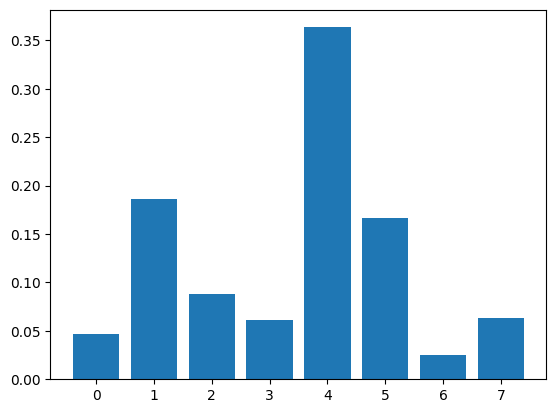

In [ ]:
plot_1d_tensor(F.softmax(torch.tensor([-0.9941,  0.3928, -0.3508, -0.7158,  1.0622,  0.2786, -1.6282, -0.6915]), dim=-1))

You can see the the output of softmax here is diffuse. None of the output values are overly large or small. If you multiply these same values by `math.sqrt(head_size)`, effectively undoing scaling we applied, you will see that the results after softmax are less evenly distributed or diffuse.

tensor([2.3960e-04, 6.1487e-02, 3.1406e-03, 7.2937e-04, 8.9464e-01, 3.8940e-02,
        1.8965e-05, 8.0382e-04])


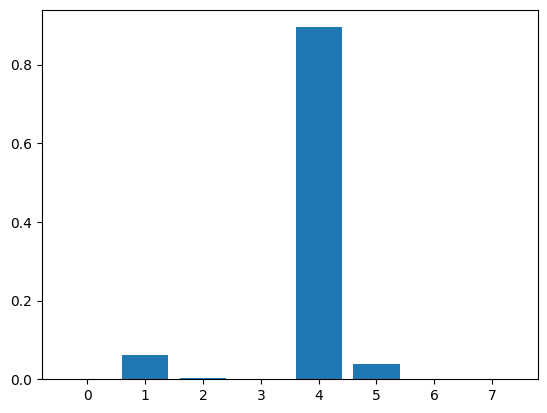

In [ ]:
#| output: true
plot_1d_tensor(F.softmax(torch.tensor([-0.9941,  0.3928, -0.3508, -0.7158,  1.0622,  0.2786, -1.6282, -0.6915])*math.sqrt(head_size), dim=-1))

If you push it even further you can see that the second item in the vector continues to grow even though the value of each element, relative to eachother has not changed.

tensor([5.1446e-15, 2.2311e-05, 1.5187e-10, 4.4175e-13, 9.9997e-01, 3.5890e-06,
        2.0192e-19, 6.5168e-13])


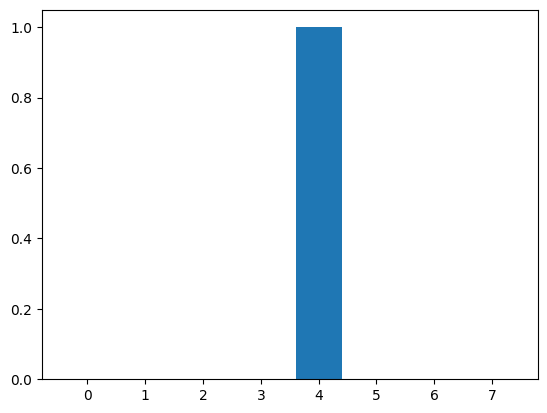

In [ ]:
#| output: true
plot_1d_tensor(F.softmax(torch.tensor([-0.9941,  0.3928, -0.3508, -0.7158,  1.0622,  0.2786, -1.6282, -0.6915])*head_size, dim=-1))

As the input values to the softmax continue to grow the result of the `softmax` continues to converge to a one-hot encoded vector, which is where one of the values in the vector is 1 and all the rest are 0's. In effect this would make it so 1 node will only draw information from one other node, which is generally not what we want. This is especially a problem during initialization of the network before training, as it can be difficult for the network to recover from this during training.

## Continuing model definition

Now we're going to create a `Head` module where we'll implement a single self attention head which we'll use in our transformer, replacing the bigram model. You can reference the video [link](https://youtu.be/kCc8FmEb1nY?t=4752) here to follow along if you would like.

In [ ]:
#| output: true
class Head(nn.Module):
    """ one self attention head """
    def __init__(self, head_size:int=head_size, embedding_dim:int=embedding_dim, context_length:int=context_length):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.head_size = head_size
        self.context_length = context_length
        self.key_layer   = nn.Linear(in_features=self.embedding_dim, out_features=self.head_size, bias=False)
        self.query_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.head_size, bias=False)
        self.value_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones((self.context_length, self.context_length))))

    def forward(self, x):
        B,T,C = x.shape
        assert T <= self.context_length #check that x.shape matches pre-defined dims
        assert C == self.embedding_dim
        q = self.query_layer(x) #(B,T,C) (batch size, context length, head_size
        k = self.key_layer(x) #(B,T,C)
        v = self.value_layer(x) #(B,T,C)

        #compute scores based on affinities
        weights = (q @ k.transpose(-2,-1)) * self.head_size**-0.5 # (B,T,C) @ (B,C,T) -> (B,T,T)
        weights = weights.masked_fill(self.tril[:T,:T] == 0, float('-inf')) #(B,T,T)
        weights = F.softmax(input=weights, dim=-1) #(B,T,T)

        #perform weighted aggragation of the values
        out = weights @ v # (B,T,T) @ (B,T,C) -> (B,T,C)
        return out

# Head()(x)

The `register_buffer` method is utilized to incorporate the tril matrix as a part of the model's state. This integration ensures that tril is consistently saved and loaded with the model, maintaining uniform behavior across various runs and settings. Crucially, being a buffer, tril is excluded from gradient calculations and is not included as a `parameter` during model optimization, thereby rendering it a non-trainable component of the model.

To make visualizing the training loss easier we'll create a simple function to plot them.

In [ ]:
#| output: true
def plot_losses(losses):
    train_losses = [o['train'] for o in losses if o.get('train') is not None]
    valid_losses = [o['valid'] for o in losses if o.get('valid') is not None]
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.show()

Now we'll add our new `Head` implementation to the `TransformerLanguageModel` class and train a model to ensure everything is working as well as to get a baseline of the results. Note we are also adding a `token_position_embedding_table` to encode the token positions. This learned looked up value will be added to the `token_embeddings`.

In [ ]:
#| output: true
learning_rate = 1e-3 # decreate the learning rate because self attention cannot tolerate very high learning rates.
max_iters = 5000

Step: 0 Training Loss: tensor(4.1743) Validation Loss: tensor(4.1712)
Step: 200 Training Loss: tensor(3.1199) Validation Loss: tensor(3.1343)
Step: 400 Training Loss: tensor(2.8712) Validation Loss: tensor(2.8892)
Step: 600 Training Loss: tensor(2.7071) Validation Loss: tensor(2.7260)
Step: 800 Training Loss: tensor(2.6324) Validation Loss: tensor(2.6392)
Step: 1000 Training Loss: tensor(2.5896) Validation Loss: tensor(2.5849)
Step: 1200 Training Loss: tensor(2.5460) Validation Loss: tensor(2.5497)
Step: 1400 Training Loss: tensor(2.5158) Validation Loss: tensor(2.5259)
Step: 1600 Training Loss: tensor(2.5000) Validation Loss: tensor(2.5051)
Step: 1800 Training Loss: tensor(2.4885) Validation Loss: tensor(2.4980)
Step: 2000 Training Loss: tensor(2.4632) Validation Loss: tensor(2.4858)
Step: 2200 Training Loss: tensor(2.4572) Validation Loss: tensor(2.4797)
Step: 2400 Training Loss: tensor(2.4632) Validation Loss: tensor(2.4467)
Step: 2600 Training Loss: tensor(2.4587) Validation Loss: 

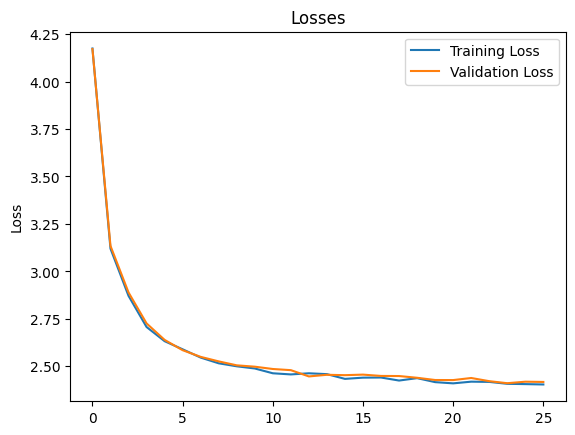


And thef tridcowind tis n, ber

Hiset bobe toe.
S:
O-' my dalatanss:
Want he uw hathe.
War dthas ate awice my.

Haldaru zorou wabuts, tof is hy me mil ndill, aes iree sen cin lat Het drovets, and Win ng:
Wilerabous lplind peallllishe onchiry:
Augr aiss hawty.

'Thake norodpeeelaves
Momy.
Whod mothake onWindo whe Ceiiby, wout, fourive wees ired thoous
Ar-x's uhe kad nterthirf so;
Angis! m:
E nge male ont ffaf Pre?

WISo myat houre!

Widby ak
Sadsal thes ghe thidin cour ay aney Iry ts chan th voul


In [ ]:
#| output: true
torch.manual_seed(TORCH_SEED)
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size:int=vocab_size, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 head_size:int=head_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = head_size

        #This will be our lookup table for embeddings. We'll have an entry for each token (aka vocab size) and each embedding will...
        #...be a vector of dimension embedding_dim.
        self.token_embedding_table = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)
        self.token_position_embedding_table = nn.Embedding(num_embeddings=self.context_length, embedding_dim=self.embedding_dim)

        self.self_attention_head_linear_layer = Head(head_size=head_size, embedding_dim=embedding_dim, context_length=context_length)
        self.language_model_head_linear_layer = nn.Linear(in_features=self.head_size, out_features=self.vocab_size)

    def forward(self, idx, targets=None):
        #Both idx and targets are (B,T) Batch x Time array of integers
        B,T = idx.shape
        token_embeddings = self.token_embedding_table(idx) #(B,T,C) Batch, Time, Channel
        token_position_embeddings = self.token_position_embedding_table(torch.arange(T, device=device)) #(T,C)
        x = token_embeddings + token_position_embeddings
        x = self.self_attention_head_linear_layer(x) #apply one head of self attention
        logits = self.language_model_head_linear_layer(x) #(B,T,C) Where C is now token logits of size vocab_size

        if targets is not None:
            B,T,C = logits.shape
            logits_reshaped = logits.view(B*T,C)
            targets_reshaped = targets.view(B*T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss=None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        #idx is (B,T) array of indicies in the current context
        for _ in range(max_new_tokens):
            #Crop idx to the max size of our positional embeddings table
            idx_crop = idx[:,-self.context_length:]
            #Get predictions
            logits, loss = self(idx_crop)
            #Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:,-1,:] #Becomes (B,C)
            # print('Shape of logits_last_timestep:',logits_last_timestep.shape) #confirming shape
            #Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1) #(B,C)
            # print('Shape of probs:', probs.shape) #confirming shape
            #Sample from the probs distribution.
            idx_next = torch.multinomial(input=probs, num_samples=1) #(B,1) Returns (B,idxs) where idxs are random integer indicies.
            # print('Shape of idx_next:',idx_next.shape,'and contents:',idx_next) #look at the shape and contents of idx_next
            #Append the sampled indexes idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1) #(B, T+1)
        return idx

model = TransformerLanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, context_length=context_length)
model = model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
tracked_losses = list()
for step in range(max_iters):

    if step % eval_iters == 0 or step == max_iters-1:
        losses = estimate_loss()
        tracked_losses.append(losses)
        print('Step:',step,'Training Loss:',losses['train'],'Validation Loss:',losses['valid'])

    xb,yb = get_batch('train')
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

plot_losses(tracked_losses)
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context,max_new_tokens=500)[0].tolist()))

Next we'll add multi-head attention which is just computing multiple attention heads together in parallel and then concatenating the results.
![Multi head attention formula](https://github.com/matdmiller/blog/blob/main/posts/2023-06-10_transformers/multi_head_attention1.png?raw=1)

In [ ]:
#| output: true
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads:int, head_size:int=head_size, embedding_dim:int=embedding_dim, context_length:int=context_length):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.embedding_dim = embedding_dim
        self.context_length = context_length

        self.heads = nn.ModuleList([
            Head(head_size=self.head_size, embedding_dim=self.embedding_dim, context_length=self.context_length)
            for _ in range(self.num_heads)
        ])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1) #Note the concat is in the last 'C' dimension => (B,T,C*num_heads)


Now let's add our newly created multi-head attention back into our Model.

Step: 0 Training Loss: tensor(4.2248) Validation Loss: tensor(4.2250)
Step: 200 Training Loss: tensor(3.0112) Validation Loss: tensor(3.0132)
Step: 400 Training Loss: tensor(2.7330) Validation Loss: tensor(2.7487)
Step: 600 Training Loss: tensor(2.6190) Validation Loss: tensor(2.6244)
Step: 800 Training Loss: tensor(2.5537) Validation Loss: tensor(2.5700)
Step: 1000 Training Loss: tensor(2.5222) Validation Loss: tensor(2.5220)
Step: 1200 Training Loss: tensor(2.4785) Validation Loss: tensor(2.4870)
Step: 1400 Training Loss: tensor(2.4509) Validation Loss: tensor(2.4563)
Step: 1600 Training Loss: tensor(2.4205) Validation Loss: tensor(2.4278)
Step: 1800 Training Loss: tensor(2.3966) Validation Loss: tensor(2.4144)
Step: 2000 Training Loss: tensor(2.3658) Validation Loss: tensor(2.3828)
Step: 2200 Training Loss: tensor(2.3729) Validation Loss: tensor(2.3910)
Step: 2400 Training Loss: tensor(2.3579) Validation Loss: tensor(2.3466)
Step: 2600 Training Loss: tensor(2.3544) Validation Loss: 

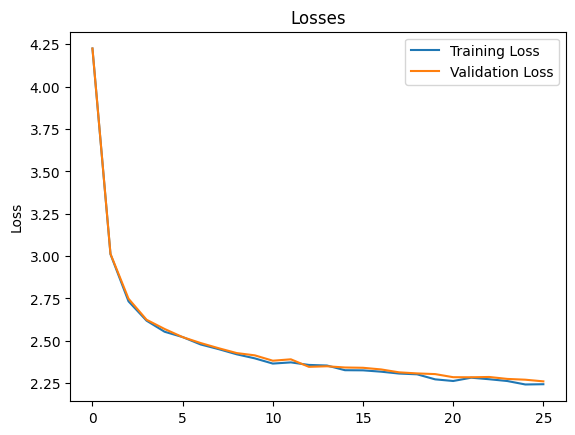


And they tridcowd,
This so be madises bube to tavegr-'t theall ands:
Want he us hat tot?
Wedtlas anes wice my.

HDER:
At onoth
Youts, tof is hy me mil nowlit,
Wheirwe sen cin lat Het drov the and the nown iserans!
 lolind teall thus, cocrivy prugh aiss hewty.
Hllings kne
To thig I whom.

Whoul to ake onWinso whre piiby we atit,
Crive winghience poo mo the thu the danterupt fis are;
De! muf thre male of,
To fis.
Fe I So myakny, be!
Whied is:
Sadsal the E'd st huin couk ay andy Iry to cof my carey


In [ ]:
#| output: true
torch.manual_seed(TORCH_SEED)
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size:int=vocab_size, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 head_size:int=head_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = head_size

        #This will be our lookup table for embeddings. We'll have an entry for each token (aka vocab size) and each embedding will...
        #...be a vector of dimension embedding_dim.
        self.token_embedding_table = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)
        self.token_position_embedding_table = nn.Embedding(num_embeddings=self.context_length, embedding_dim=self.embedding_dim)

        # self.self_attention_head_linear_layer = Head(head_size=head_size, embedding_dim=embedding_dim, context_length=context_length)
        #4 heads of 8 dimensional self attention.
        self.multi_self_attention_heads_layer = MultiHeadAttention(num_heads=4, head_size=self.embedding_dim//4) #NEW
        self.language_model_head_linear_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.vocab_size)

    def forward(self, idx, targets=None):
        #Both idx and targets are (B,T) Batch x Time array of integers
        B,T = idx.shape
        token_embeddings = self.token_embedding_table(idx) #(B,T,C) Batch, Time, Channel
        token_position_embeddings = self.token_position_embedding_table(torch.arange(T, device=device)) #(T,C)
        x = token_embeddings + token_position_embeddings
        # x = self.self_attention_head_linear_layer(x) #apply one head of self attention
        x = self.multi_self_attention_heads_layer(x)
        logits = self.language_model_head_linear_layer(x) #(B,T,C) Where C is now token logits of size vocab_size

        if targets is not None:
            B,T,C = logits.shape
            logits_reshaped = logits.view(B*T,C)
            targets_reshaped = targets.view(B*T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss=None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        #idx is (B,T) array of indicies in the current context
        for _ in range(max_new_tokens):
            #Crop idx to the max size of our positional embeddings table
            idx_crop = idx[:,-self.context_length:]
            #Get predictions
            logits, loss = self(idx_crop)
            #Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:,-1,:] #Becomes (B,C)
            # print('Shape of logits_last_timestep:',logits_last_timestep.shape) #confirming shape
            #Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1) #(B,C)
            # print('Shape of probs:', probs.shape) #confirming shape
            #Sample from the probs distribution.
            idx_next = torch.multinomial(input=probs, num_samples=1) #(B,1) Returns (B,idxs) where idxs are random integer indicies.
            # print('Shape of idx_next:',idx_next.shape,'and contents:',idx_next) #look at the shape and contents of idx_next
            #Append the sampled indexes idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1) #(B, T+1)
        return idx

model = TransformerLanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, context_length=context_length)
model = model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
tracked_losses = list()
for step in range(max_iters):

    if step % eval_iters == 0 or step == max_iters-1:
        losses = estimate_loss()
        tracked_losses.append(losses)
        print('Step:',step,'Training Loss:',losses['train'],'Validation Loss:',losses['valid'])

    xb,yb = get_batch('train')
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

plot_losses(tracked_losses)
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context,max_new_tokens=500)[0].tolist()))

As you can see there is quite an improvement in the loss, going from `Validation Loss: tensor(2.4176)` with a single attention head to `Validation Loss: tensor(2.2609)` with our multi-attention head that has 4 heads. Note, these losses may vary somewhat between training runs.  The results are still nonsense, but are looking closer to the training text than previous attempts. The reason that multi-headed attention works better than a single self attention block is that it is helpful to have multiple communication channels between tokens so they can each be looking for different things over different communication channels. As an example one communication channel make be looking back at vowels or consonants while another might be looking for the previous space.<br>

If you look at this transformer block diagram, you can see that we've implemented quite a bit of it so far.<br>
![transformer architecture diagram](https://github.com/matdmiller/blog/blob/main/posts/2023-06-10_transformers/transformer_architecture_diagram2.png?raw=1)<br>

We've implemented the output embeddings, positional embeddings, (the lower) masked multi-head attention, and the final linear and softmax layers. We are going to skip the multi-head attention block in the middle as that is only needed if your model has an encoder block, which ours does not. This leaves the feed forward network to implement which is just a simple multi layer perceptron. In addition the entire block between the positional encodings and final linear layer can be stacked on top of itself multiple times signified by Nx.<br>

Here is the equation for the feed forward network, which is a simple multi layer perceptron: <br>
![feed_forward_network_mlp1.png](https://github.com/matdmiller/blog/blob/main/posts/2023-06-10_transformers/feed_forward_network_mlp1.png?raw=1)

In [ ]:
#| output: true
class FeedForwardNetwork(nn.Module):
    """A simple linear network followed by a non-linearity"""
    def __init__(self, embedding_dim:int=embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.ffn = nn.Sequential(
            nn.Linear(in_features=self.embedding_dim, out_features=self.embedding_dim),
            nn.ReLU()
        )
    def forward(self, x):
        return self.ffn(x)

Note: In the equation it defines a (linear layer), (relu), and (linear layer). We'll add the final linear layer later.<br>
Now let's add our FFN to our Transformer Model.

Step: 0 Training Loss: tensor(4.2022) Validation Loss: tensor(4.2019)
Step: 200 Training Loss: tensor(2.9494) Validation Loss: tensor(2.9685)
Step: 400 Training Loss: tensor(2.6759) Validation Loss: tensor(2.6864)
Step: 600 Training Loss: tensor(2.5779) Validation Loss: tensor(2.5799)
Step: 800 Training Loss: tensor(2.5171) Validation Loss: tensor(2.5197)
Step: 1000 Training Loss: tensor(2.4739) Validation Loss: tensor(2.4703)
Step: 1200 Training Loss: tensor(2.4210) Validation Loss: tensor(2.4260)
Step: 1400 Training Loss: tensor(2.4079) Validation Loss: tensor(2.4106)
Step: 1600 Training Loss: tensor(2.3841) Validation Loss: tensor(2.3845)
Step: 1800 Training Loss: tensor(2.3684) Validation Loss: tensor(2.3734)
Step: 2000 Training Loss: tensor(2.3387) Validation Loss: tensor(2.3474)
Step: 2200 Training Loss: tensor(2.3340) Validation Loss: tensor(2.3497)
Step: 2400 Training Loss: tensor(2.3178) Validation Loss: tensor(2.3126)
Step: 2600 Training Loss: tensor(2.3174) Validation Loss: 

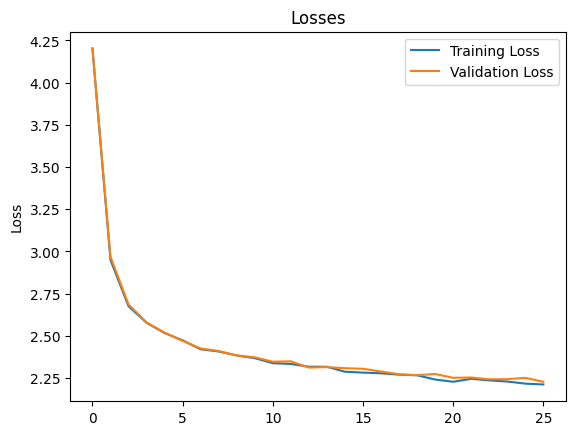


Wher bef bridcowf,
The lay be madiret bube to tave O-' my dalllauss:
Want he us hathert?
Wedtlacoate awill my thand a wizorm he owns, to fit her! Varl nowlit,
Wheiree sen cin lat Heacliov the and the now on you mes lill dime litens;
Honcelf sprup; aiss hit yevell nal nord patelave whom
Ill, demet aklecal-'so wher piichs withe dour warce hidend thoouse the the the danderthirf son; igis! muf thre ifled at tise Pried my of.

HKINGLER:
Widby and adsal ther grest hoin cour ay aney Iry thel fronf veay
CPU times: user 58.6 s, sys: 479 ms, total: 59.1 s
Wall time: 59.5 s


In [ ]:
%%time
#| output: true
torch.manual_seed(TORCH_SEED)
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size:int=vocab_size, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 head_size:int=head_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = head_size

        #This will be our lookup table for embeddings. We'll have an entry for each token (aka vocab size) and each embedding will...
        #...be a vector of dimension embedding_dim.
        self.token_embedding_table = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)
        self.token_position_embedding_table = nn.Embedding(num_embeddings=self.context_length, embedding_dim=self.embedding_dim)

        #4 heads of 8 dimensional self attention.
        self.multi_self_attention_heads_layer = MultiHeadAttention(num_heads=4, head_size=self.embedding_dim//4)
        self.feed_forward_network = FeedForwardNetwork(embedding_dim=self.embedding_dim) #NEW
        self.language_model_head_linear_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.vocab_size)

    def forward(self, idx, targets=None):
        #Both idx and targets are (B,T) Batch x Time array of integers
        B,T = idx.shape
        token_embeddings = self.token_embedding_table(idx) #(B,T,C) Batch, Time, Channel
        token_position_embeddings = self.token_position_embedding_table(torch.arange(T, device=device)) #(T,C)
        x = token_embeddings + token_position_embeddings
        x = self.multi_self_attention_heads_layer(x) # (B,T,C)
        x = self.feed_forward_network(x) # (B,T,C) NEW
        logits = self.language_model_head_linear_layer(x) #(B,T,C) Where C is now token logits of size vocab_size

        if targets is not None:
            B,T,C = logits.shape
            logits_reshaped = logits.view(B*T,C)
            targets_reshaped = targets.view(B*T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss=None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        #idx is (B,T) array of indicies in the current context
        for _ in range(max_new_tokens):
            #Crop idx to the max size of our positional embeddings table
            idx_crop = idx[:,-self.context_length:]
            #Get predictions
            logits, loss = self(idx_crop)
            #Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:,-1,:] #Becomes (B,C)
            # print('Shape of logits_last_timestep:',logits_last_timestep.shape) #confirming shape
            #Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1) #(B,C)
            # print('Shape of probs:', probs.shape) #confirming shape
            #Sample from the probs distribution.
            idx_next = torch.multinomial(input=probs, num_samples=1) #(B,1) Returns (B,idxs) where idxs are random integer indicies.
            # print('Shape of idx_next:',idx_next.shape,'and contents:',idx_next) #look at the shape and contents of idx_next
            #Append the sampled indexes idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1) #(B, T+1)
        return idx

model = TransformerLanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, context_length=context_length)
model = model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
tracked_losses = list()
for step in range(max_iters):

    if step % eval_iters == 0 or step == max_iters-1:
        losses = estimate_loss()
        tracked_losses.append(losses)
        print('Step:',step,'Training Loss:',losses['train'],'Validation Loss:',losses['valid'])

    xb,yb = get_batch('train')
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

plot_losses(tracked_losses)
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context,max_new_tokens=500)[0].tolist()))

Our loss has improved again from `Validation Loss: tensor(2.2854)` now to `Validation Loss: tensor(2.2720)` now that we've added the feed forward network.<br>

Next we need to create a Block module that incorporates everthing within the block on the transformer architecture diagram (grey box) which will then allow us to stack them.

In [ ]:
#| output: true
class TransformerBlock(nn.Module):
    """Transformer Block: Communication folled by computation."""
    def __init__(self, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 num_heads:int=4):
        #embedding_dim: embedding dimension, num_heads: the number of heads that we want
        super().__init__()
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = embedding_dim // num_heads
        self.num_heads = num_heads

        self.multi_self_attention_heads_layer = MultiHeadAttention(num_heads=self.num_heads, head_size=self.head_size,
                                                                   embedding_dim=embedding_dim, context_length=context_length)
        self.feed_forward_network = FeedForwardNetwork(embedding_dim=self.embedding_dim)

    def forward(self, x):
        return self.feed_forward_network(self.multi_self_attention_heads_layer(x))


Now we can add our new Transformer Block to our model and start stacking it.

Step: 0 Training Loss: tensor(4.2116) Validation Loss: tensor(4.2078)
Step: 200 Training Loss: tensor(3.2643) Validation Loss: tensor(3.2907)
Step: 400 Training Loss: tensor(3.1541) Validation Loss: tensor(3.1676)
Step: 600 Training Loss: tensor(3.0373) Validation Loss: tensor(3.0268)
Step: 800 Training Loss: tensor(2.8424) Validation Loss: tensor(2.8325)
Step: 1000 Training Loss: tensor(2.7689) Validation Loss: tensor(2.7531)
Step: 1200 Training Loss: tensor(2.6844) Validation Loss: tensor(2.7028)
Step: 1400 Training Loss: tensor(2.6433) Validation Loss: tensor(2.6416)
Step: 1600 Training Loss: tensor(2.6092) Validation Loss: tensor(2.6048)
Step: 1800 Training Loss: tensor(2.5641) Validation Loss: tensor(2.5776)
Step: 2000 Training Loss: tensor(2.5276) Validation Loss: tensor(2.5285)
Step: 2200 Training Loss: tensor(2.5021) Validation Loss: tensor(2.5106)
Step: 2400 Training Loss: tensor(2.4903) Validation Loss: tensor(2.4736)
Step: 2600 Training Loss: tensor(2.4576) Validation Loss: 

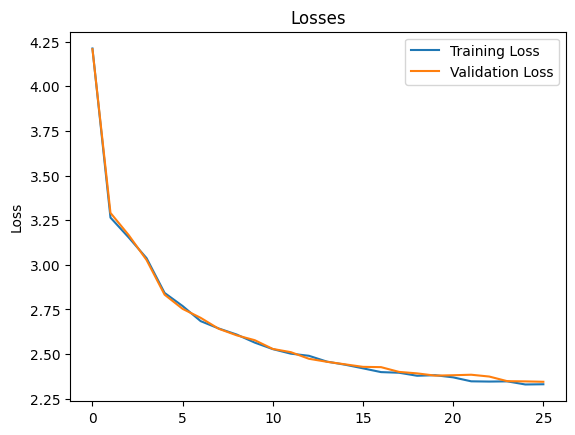




CODARIRZ:
Thowd, hy sou, be masiset bobe toe.
Sagr-' my dalatanss:
Wart he uwece, vet?
Fedtlasoate aw crugy.

Hasdacut onou,
Yowts, tof is her! Alil;
I lon,
Whiiree sen cin latiset drov the and the nor on yracous lhin dite herens;
Honcive sothpe arss hewty. Hintn.
In Boopetelives
Mom
Il woul to ak
ao Wind to doreiiby we at to srive wees ire stisot

Arixorg
Tep add thruptef sor; iris! mefve, ey ald ontatesf Prred my om.

Heroure!
Ko you a wardsal ar hared thidin cour ay andy Iry to I fo the!
My
CPU times: user 2min 3s, sys: 653 ms, total: 2min 4s
Wall time: 2min 4s


In [ ]:
%%time
#| output: true
torch.manual_seed(TORCH_SEED)
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size:int=vocab_size, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 head_size:int=head_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = head_size

        #This will be our lookup table for embeddings. We'll have an entry for each token (aka vocab size) and each embedding will...
        #...be a vector of dimension embedding_dim.
        self.token_embedding_table = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)
        self.token_position_embedding_table = nn.Embedding(num_embeddings=self.context_length, embedding_dim=self.embedding_dim)

        # self.multi_self_attention_heads_layer = MultiHeadAttention(num_heads=4, head_size=self.embedding_dim//4)
        # self.feed_forward_network = FeedForwardNetwork(embedding_dim=self.embedding_dim)
        self.transformer_blocks = nn.Sequential(
            TransformerBlock(embedding_dim=embedding_dim, num_heads=4, context_length=context_length),
            TransformerBlock(embedding_dim=embedding_dim, num_heads=4, context_length=context_length),
            TransformerBlock(embedding_dim=embedding_dim, num_heads=4, context_length=context_length),
        ) #NEW
        self.language_model_head_linear_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.vocab_size)

    def forward(self, idx, targets=None):
        #Both idx and targets are (B,T) Batch x Time array of integers
        B,T = idx.shape
        token_embeddings = self.token_embedding_table(idx) #(B,T,C) Batch, Time, Channel
        token_position_embeddings = self.token_position_embedding_table(torch.arange(T, device=device)) #(T,C)
        x = token_embeddings + token_position_embeddings
        # x = self.multi_self_attention_heads_layer(x) # (B,T,C)
        # x = self.feed_forward_network(x) # (B,T,C)
        x = self.transformer_blocks(x) #NEW
        logits = self.language_model_head_linear_layer(x) #(B,T,C) Where C is now token logits of size vocab_size

        if targets is not None:
            B,T,C = logits.shape
            logits_reshaped = logits.view(B*T,C)
            targets_reshaped = targets.view(B*T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss=None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        #idx is (B,T) array of indicies in the current context
        for _ in range(max_new_tokens):
            #Crop idx to the max size of our positional embeddings table
            idx_crop = idx[:,-self.context_length:]
            #Get predictions
            logits, loss = self(idx_crop)
            #Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:,-1,:] #Becomes (B,C)
            # print('Shape of logits_last_timestep:',logits_last_timestep.shape) #confirming shape
            #Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1) #(B,C)
            # print('Shape of probs:', probs.shape) #confirming shape
            #Sample from the probs distribution.
            idx_next = torch.multinomial(input=probs, num_samples=1) #(B,1) Returns (B,idxs) where idxs are random integer indicies.
            # print('Shape of idx_next:',idx_next.shape,'and contents:',idx_next) #look at the shape and contents of idx_next
            #Append the sampled indexes idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1) #(B, T+1)
        return idx

model = TransformerLanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, context_length=context_length)
model = model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
tracked_losses = list()
for step in range(max_iters):

    if step % eval_iters == 0 or step == max_iters-1:
        losses = estimate_loss()
        tracked_losses.append(losses)
        print('Step:',step,'Training Loss:',losses['train'],'Validation Loss:',losses['valid'])

    xb,yb = get_batch('train')
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

plot_losses(tracked_losses)
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context,max_new_tokens=500)[0].tolist()))

As you can see the accuracy actually got worse. Given our new much more powerful model, this is not something that we want. As the depth of models increase they can become harder to train. Fortunately there are a few things that we can do about that. [link](https://youtu.be/kCc8FmEb1nY?t=5208)<br>

First we can implement skip connections, also known as residual connections, which are depicted on the transformer architecture diagram as black lines that bypass the masked multi-head attention block and feed into the add and norm block. You can also see one bypassing the FFN. The idea for these originally came from deep residual networks paper. In this case we are going to add the input data back to the output of the blocks that are being skipped. When you use addition, the gradients are evenly distributed between both the skip branch and the block branch. An alternative that is sometimes used is a simple concatenation of the input and output of the skipped block. <br>

When we initialize the network before training we typically want to start off with very low weights for the branches that go through the blocks so the blocks contribute very little to the overall loss. This way the gradient signal makes its way through the entire network. Then during training the network will slowly increase the weights and participation of the blocks.

Now let's implement the skip connections in our TransfomerBlock module.

In [ ]:
#| output: true
class TransformerBlock(nn.Module):
    """Transformer Block: Communication folled by computation."""
    def __init__(self, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 num_heads:int=4):
        #embedding_dim: embedding dimension, num_heads: the number of heads that we want
        super().__init__()
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = embedding_dim // num_heads
        self.num_heads = num_heads

        self.multi_self_attention_heads_layer = MultiHeadAttention(num_heads=self.num_heads, head_size=self.head_size,
                                                                   embedding_dim=embedding_dim, context_length=context_length)
        self.feed_forward_network = FeedForwardNetwork(embedding_dim=self.embedding_dim)

    def forward(self, x):
        # return self.feed_forward_network(self.multi_self_attention_heads_layer(x))
        x = x + self.multi_self_attention_heads_layer(x) # adding input back to the output of each block for skip connection. NEW
        x = x + self.feed_forward_network(x) # adding input back to the output of each block for skip connection. NEW
        return x


We also need to add a projection layer to our MultiHeadAttention module as well as the feed forward network. This is a simple linear layer.

In [ ]:
#| output: true
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads:int, head_size:int=head_size, embedding_dim:int=embedding_dim, context_length:int=context_length):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.embedding_dim = embedding_dim
        self.context_length = context_length

        self.heads = nn.ModuleList([
            Head(head_size=self.head_size, embedding_dim=self.embedding_dim,
                 context_length=self.context_length)
            for _ in range(self.num_heads)])

        self.projection_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.embedding_dim, bias=True) #NEW

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.projection_layer(out) #NEW
        return out


In the FFN rather than adding the same projection layer parameter we'll simply just add an additional linear layer to the existing sequential module. Also we are going to fan out and then back in by a factor of 4 between the linear layers in the FFN to add additional computation.

In [ ]:
#| output: true
class FeedForwardNetwork(nn.Module):
    """A simple linear network followed by a non-linearity"""
    def __init__(self, embedding_dim:int=embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.ffn = nn.Sequential(
            nn.Linear(in_features=self.embedding_dim, out_features=self.embedding_dim*4),#Updated
            nn.ReLU(),
            nn.Linear(in_features=self.embedding_dim*4, out_features=self.embedding_dim) #NEW
        )
    def forward(self, x):
        return self.ffn(x)

Now let's train the network again to see how we end up.

Step: 0 Training Loss: tensor(4.6328) Validation Loss: tensor(4.6313)
Step: 200 Training Loss: tensor(2.5777) Validation Loss: tensor(2.5964)
Step: 400 Training Loss: tensor(2.4484) Validation Loss: tensor(2.4357)
Step: 600 Training Loss: tensor(2.3560) Validation Loss: tensor(2.3456)
Step: 800 Training Loss: tensor(2.2822) Validation Loss: tensor(2.2928)
Step: 1000 Training Loss: tensor(2.2413) Validation Loss: tensor(2.2606)
Step: 1200 Training Loss: tensor(2.2254) Validation Loss: tensor(2.2469)
Step: 1400 Training Loss: tensor(2.1889) Validation Loss: tensor(2.2146)
Step: 1600 Training Loss: tensor(2.1566) Validation Loss: tensor(2.1969)
Step: 1800 Training Loss: tensor(2.1442) Validation Loss: tensor(2.1958)
Step: 2000 Training Loss: tensor(2.1438) Validation Loss: tensor(2.1545)
Step: 2200 Training Loss: tensor(2.1293) Validation Loss: tensor(2.1731)
Step: 2400 Training Loss: tensor(2.0948) Validation Loss: tensor(2.1550)
Step: 2600 Training Loss: tensor(2.0839) Validation Loss: 

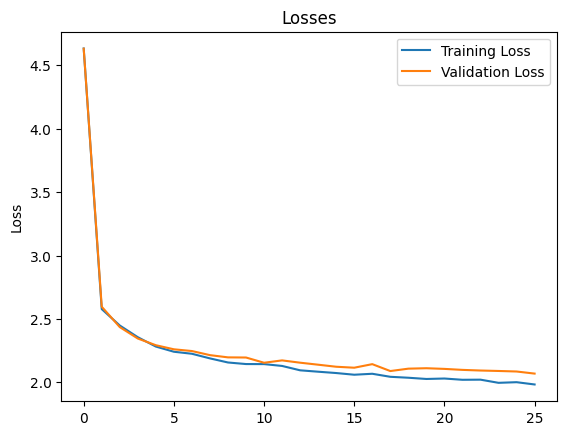


And they bridcerf,
The lay ble

HAPOMEMBELA:
And thruans that hand bartht he us his vet?

MEXENDorten with my feans,
You or me
Yoursertef it her that welill, at mire,
Ever, will is tiliove thee.

WARGEE:
We you me, lilind tear.
-huch cochink: the baiss hit ye will,
Hen Band this dest my liked mothake of in on her evings to thed suil Then hime stisor of he trued known,
Turt fir are;
I to lave,
I male of whise Pried my of.

HENNIUS:
Kereby a wards.
Wice Elet thinin cour ay andy Rell sichan the!

J
CPU times: user 2min 13s, sys: 636 ms, total: 2min 13s
Wall time: 2min 14s


In [ ]:
%%time
#| output: true
torch.manual_seed(TORCH_SEED)
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size:int=vocab_size, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 head_size:int=head_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = head_size

        #This will be our lookup table for embeddings. We'll have an entry for each token (aka vocab size) and each embedding will...
        #...be a vector of dimension embedding_dim.
        self.token_embedding_table = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)
        self.token_position_embedding_table = nn.Embedding(num_embeddings=self.context_length, embedding_dim=self.embedding_dim)

        self.transformer_blocks = nn.Sequential(
            TransformerBlock(embedding_dim=embedding_dim, num_heads=4, context_length=context_length),
            TransformerBlock(embedding_dim=embedding_dim, num_heads=4, context_length=context_length),
            TransformerBlock(embedding_dim=embedding_dim, num_heads=4, context_length=context_length),
        )
        self.language_model_head_linear_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.vocab_size)

    def forward(self, idx, targets=None):
        #Both idx and targets are (B,T) Batch x Time array of integers
        B,T = idx.shape
        token_embeddings = self.token_embedding_table(idx) #(B,T,C) Batch, Time, Channel
        token_position_embeddings = self.token_position_embedding_table(torch.arange(T, device=device)) #(T,C)
        x = token_embeddings + token_position_embeddings
        x = self.transformer_blocks(x)
        logits = self.language_model_head_linear_layer(x) #(B,T,C) Where C is now token logits of size vocab_size

        if targets is not None:
            B,T,C = logits.shape
            logits_reshaped = logits.view(B*T,C)
            targets_reshaped = targets.view(B*T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss=None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        #idx is (B,T) array of indicies in the current context
        for _ in range(max_new_tokens):
            #Crop idx to the max size of our positional embeddings table
            idx_crop = idx[:,-self.context_length:]
            #Get predictions
            logits, loss = self(idx_crop)
            #Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:,-1,:] #Becomes (B,C)
            # print('Shape of logits_last_timestep:',logits_last_timestep.shape) #confirming shape
            #Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1) #(B,C)
            # print('Shape of probs:', probs.shape) #confirming shape
            #Sample from the probs distribution.
            idx_next = torch.multinomial(input=probs, num_samples=1) #(B,1) Returns (B,idxs) where idxs are random integer indicies.
            # print('Shape of idx_next:',idx_next.shape,'and contents:',idx_next) #look at the shape and contents of idx_next
            #Append the sampled indexes idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1) #(B, T+1)
        return idx

model = TransformerLanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, context_length=context_length)
model = model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
tracked_losses = list()
for step in range(max_iters):

    if step % eval_iters == 0 or step == max_iters-1:
        losses = estimate_loss()
        tracked_losses.append(losses)
        print('Step:',step,'Training Loss:',losses['train'],'Validation Loss:',losses['valid'])

    xb,yb = get_batch('train')
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

plot_losses(tracked_losses)
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context,max_new_tokens=500)[0].tolist()))

This looks much better than our last run without the residual layers which had a loss of `Validation Loss: tensor(2.4430)` and it also beats the previous run before that had a los of `Validation Loss: tensor(2.2720)` with a final loss of `Validation Loss: tensor(2.0940)`. Also, as you can see the text output, while still gibberish, is much better than in all previous runs.<br>

The second trick that helps with training deep neural nets, in addition to residual blocks, is the Norm as depicted on the block which in our case is layer norm. Let's implement and add that. [link](https://youtu.be/kCc8FmEb1nY?t=5709)

In [ ]:
#| output: true
class LayerNorm:
    def __init__(self, dim:int, eps:float=1e-5):
        self.dim = dim
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        x_mean = x.mean(dim=1, keepdim=True) # layer mean
        x_variance = x.var(dim=1, keepdim=True) # layer variance
        x_hat = (x - x_mean) / torch.sqrt(x_variance + self.eps) # normalize to the unit variance
        self.out = self.gamma * x_hat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

Since the original attention is all you need paper came out, it has become more common to apply the norm prior to the blocks instead of after them with the add as is depicted on the transformer architecture diagram. We will follow what common practice is today. Also instead of using the layer norm we developed, we will use the Pytorch version instead.

In [ ]:
#| output: true
class TransformerBlock(nn.Module):
    """Transformer Block: Communication folled by computation."""
    def __init__(self, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 num_heads:int=4):
        #embedding_dim: embedding dimension, num_heads: the number of heads that we want
        super().__init__()
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = embedding_dim // num_heads
        self.num_heads = num_heads

        self.multi_self_attention_heads_layer = MultiHeadAttention(num_heads=self.num_heads, head_size=self.head_size,
                                                                   embedding_dim=embedding_dim, context_length=context_length)
        self.feed_forward_network = FeedForwardNetwork(embedding_dim=self.embedding_dim)
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=self.embedding_dim) #NEW
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=self.embedding_dim) #NEW

    def forward(self, x):
        # return self.feed_forward_network(self.multi_self_attention_heads_layer(x))
        x = x + self.multi_self_attention_heads_layer(self.layer_norm_1(x)) # added layer norm. UPDATED
        x = x + self.feed_forward_network(self.layer_norm_2(x)) # added layer norm. UPDATED
        return x


These layer norms are applied to each token embedding to ensure they start off having a unit gausian at initialization, but because of the trainable parameters, this may change during training. <br>

We also need to add a layer norm after the last transformer block and before the last linear layer. Now let's train the model again and see how it does.

Step: 0 Training Loss: tensor(4.3103) Validation Loss: tensor(4.3100)
Step: 200 Training Loss: tensor(2.6644) Validation Loss: tensor(2.6888)
Step: 400 Training Loss: tensor(2.4590) Validation Loss: tensor(2.4469)
Step: 600 Training Loss: tensor(2.3606) Validation Loss: tensor(2.3482)
Step: 800 Training Loss: tensor(2.2807) Validation Loss: tensor(2.2859)
Step: 1000 Training Loss: tensor(2.2328) Validation Loss: tensor(2.2572)
Step: 1200 Training Loss: tensor(2.2185) Validation Loss: tensor(2.2373)
Step: 1400 Training Loss: tensor(2.1743) Validation Loss: tensor(2.2099)
Step: 1600 Training Loss: tensor(2.1415) Validation Loss: tensor(2.1840)
Step: 1800 Training Loss: tensor(2.1290) Validation Loss: tensor(2.1790)
Step: 2000 Training Loss: tensor(2.1290) Validation Loss: tensor(2.1376)
Step: 2200 Training Loss: tensor(2.1120) Validation Loss: tensor(2.1576)
Step: 2400 Training Loss: tensor(2.0815) Validation Loss: tensor(2.1385)
Step: 2600 Training Loss: tensor(2.0747) Validation Loss: 

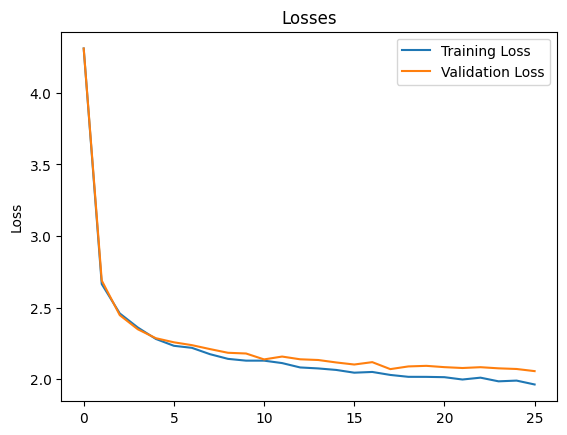


And the Roridce.

STAOLOLETHAR

HAPOKE BFe have Sagrians that hands:
Wacth full him vetbard that a endway, my feans' to zorn he owns, to fitie be trit nowle, at miree,
In cintlatise, drove the the know and.

Wablesel lind teal.
-huch cour by prupt airse, why helven's norfore elguls;
Protle, demees?

KINWICI: what eiich o' mai dourn, The high he poor of his but thand thrupt fir treagis! my my fep ale of whith Pried by of.

HKING ELIZANIUS:
I
Sadaal the Edwast hiin courchard ny ity to chan the whi
CPU times: user 2min 22s, sys: 686 ms, total: 2min 22s
Wall time: 2min 23s


In [ ]:
%%time
#| output: true
torch.manual_seed(TORCH_SEED)
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size:int=vocab_size, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 head_size:int=head_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = head_size

        #This will be our lookup table for embeddings. We'll have an entry for each token (aka vocab size) and each embedding will...
        #...be a vector of dimension embedding_dim.
        self.token_embedding_table = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)
        self.token_position_embedding_table = nn.Embedding(num_embeddings=self.context_length, embedding_dim=self.embedding_dim)

        self.transformer_blocks = nn.Sequential(
            TransformerBlock(embedding_dim=embedding_dim, num_heads=4, context_length=context_length),
            TransformerBlock(embedding_dim=embedding_dim, num_heads=4, context_length=context_length),
            TransformerBlock(embedding_dim=embedding_dim, num_heads=4, context_length=context_length),
            nn.LayerNorm(embedding_dim), #NEW
        )
        self.language_model_head_linear_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.vocab_size)

    def forward(self, idx, targets=None):
        #Both idx and targets are (B,T) Batch x Time array of integers
        B,T = idx.shape
        token_embeddings = self.token_embedding_table(idx) #(B,T,C) Batch, Time, Channel
        token_position_embeddings = self.token_position_embedding_table(torch.arange(T, device=device)) #(T,C)
        x = token_embeddings + token_position_embeddings
        x = self.transformer_blocks(x)
        logits = self.language_model_head_linear_layer(x) #(B,T,C) Where C is now token logits of size vocab_size

        if targets is not None:
            B,T,C = logits.shape
            logits_reshaped = logits.view(B*T,C)
            targets_reshaped = targets.view(B*T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss=None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        #idx is (B,T) array of indicies in the current context
        for _ in range(max_new_tokens):
            #Crop idx to the max size of our positional embeddings table
            idx_crop = idx[:,-self.context_length:]
            #Get predictions
            logits, loss = self(idx_crop)
            #Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:,-1,:] #Becomes (B,C)
            # print('Shape of logits_last_timestep:',logits_last_timestep.shape) #confirming shape
            #Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1) #(B,C)
            # print('Shape of probs:', probs.shape) #confirming shape
            #Sample from the probs distribution.
            idx_next = torch.multinomial(input=probs, num_samples=1) #(B,1) Returns (B,idxs) where idxs are random integer indicies.
            # print('Shape of idx_next:',idx_next.shape,'and contents:',idx_next) #look at the shape and contents of idx_next
            #Append the sampled indexes idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1) #(B, T+1)
        return idx

model = TransformerLanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, context_length=context_length)
model = model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
tracked_losses = list()
for step in range(max_iters):

    if step % eval_iters == 0 or step == max_iters-1:
        losses = estimate_loss()
        tracked_losses.append(losses)
        print('Step:',step,'Training Loss:',losses['train'],'Validation Loss:',losses['valid'])

    xb,yb = get_batch('train')
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

plot_losses(tracked_losses)
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context,max_new_tokens=500)[0].tolist()))

The loss is now down to `Validation Loss: tensor(2.0630)` from `Validation Loss: tensor(2.0940)` during the last run.

In [ ]:
%reset -f
#| output: true

# Scaling Up

Now that we have a fully functioning transformer network, to achieve better performance, we need to scale up. We'll be doing a bit of code cleanup and refactoring as we scale up the architecture. To make things easier to follow, I've reset the kernel so we'll be re-declaring everything again from scratch.

In [ ]:
#| output: true
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

#Hyperparameters
batch_size = 64 #Number of token chunks per batch #UPDATED
context_length = 256 #Length of the token chunks. Andrej called this block size #UPDATED
embedding_dim = 384 #The vector size of the token embeddings. Andrej used n_embed as the variable name. #UPDATED
head_size1 = 16 #Self attention head size
num_layers = 6 #Number of transformer block layers # NEW
num_heads = 6  # NEW
learning_rate = 3e-4 #UPDATED
dropout = 0.2 #NEW
max_iters = 5000 #Number of training iterations or steps.
eval_interval = 500 #Number of steps between evaluating the validation set to see how our validation loss is doing. #UPDATED
eval_iters = 200 #Number of steps to do on the validation set per each interval. We do more than 1 to get a more accurate overall valid loss
device = 'cuda' if torch.cuda.is_available() else 'cpu' #Instead of using the cpu, we'll use the GPU if it's availble.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

#Dataset
with open('input.txt','r',encoding='utf-8') as f:
    text = f.read()
vocab = sorted(list(set(text))) #Called chars in the video, but vocab is a more generic term. Both are correct.
vocab_size = len(vocab)

char2idx = {char:idx for idx,char in enumerate(vocab)}
idx2char = {idx:char for char,idx in char2idx.items()}
encode = lambda x: [char2idx[char] for char in x]
decode = lambda idxs: ''.join([idx2char[idx] for idx in idxs])

tokenized_text = torch.tensor(encode(text),dtype=torch.long)

#Train / Valid split.
train_test_split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:train_test_split_idx]
valid_data = tokenized_text[train_test_split_idx:]

In [ ]:
#| output: true
def plot_losses(losses):
    train_losses = [o['train'] for o in losses if o.get('train') is not None]
    valid_losses = [o['valid'] for o in losses if o.get('valid') is not None]
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.show()

In [ ]:
#| output: true
def get_batch(split:str, batch_size:int=batch_size, context_length:int=context_length):
    #Function to get a batch of data from the train or valid dataset
    data = train_data if split == 'train' else valid_data
    idxs = torch.randint(low=0, high=len(data)-context_length, size=(batch_size,))
    x = torch.stack([data[idx:idx+context_length] for idx in idxs])
    y = torch.stack([data[idx+1:idx+context_length+1] for idx in idxs])
    x,y = x.to(device), y.to(device) #Send data to the GPU if available
    return x,y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train','valid']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x_batch, y_batch = get_batch(split)
            logits, loss = model(x_batch, y_batch)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

Adding dropout

In [ ]:
#| output: true
class FeedForwardNetwork(nn.Module):
    """A simple linear network followed by a non-linearity"""
    def __init__(self, embedding_dim:int=embedding_dim, dropout:float=dropout):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.ffn = nn.Sequential(
            nn.Linear(in_features=self.embedding_dim, out_features=self.embedding_dim*4),
            nn.ReLU(),
            nn.Linear(in_features=self.embedding_dim*4, out_features=self.embedding_dim),
            nn.Dropout(dropout), #NEW
        )
    def forward(self, x):
        return self.ffn(x)

Adding dropout

In [ ]:
#| output: true
class Head(nn.Module):
    """ one head of self attention """
    def __init__(self, head_size:int, embedding_dim:int=embedding_dim,
                 context_length:int=context_length, dropout:float=dropout):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.head_size = head_size
        self.context_length = context_length
        self.dropout = dropout

        self.key_layer   = nn.Linear(in_features=self.embedding_dim, out_features=self.head_size, bias=False)
        self.query_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.head_size, bias=False)
        self.value_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones((self.context_length, self.context_length))))
        self.dropout_layer = nn.Dropout(dropout) # NEW

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        assert T <= self.context_length
        assert C == self.embedding_dim
        q = self.query_layer(x) #(B,T,C) (batch size, context length, head_size)
        k = self.key_layer(x) #(B,T,C) (batch size, context length, head_size)
        v = self.value_layer(x) #(B,T,C) (batch size, context length, head_size)

        #compute scores based on affinities
        weights = (q @ k.transpose(-2,-1)) * self.head_size**-0.5 # (B,T,C) @ (B,C,T) -> (B,T,T) #FIXED ^-.5 is 1/sqrt() so need to mult, not div
        weights = weights.masked_fill(self.tril[:T,:T] == 0, float('-inf')) #(B,T,T)
        weights = F.softmax(input=weights, dim=-1) #(B,T,T)
        weights = self.dropout_layer(weights) # NEW

        #perform weighted aggragation of the values
        out = weights @ v # (B,T,T) @ (B,T,C) -> (B,T,C)
        return out

# Head()(x)

Adding dropout

In [ ]:
#| output: true
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads:int, head_size:int, embedding_dim:int=embedding_dim,
                 context_length:int=context_length, dropout:float=dropout):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.dropout = dropout

        self.heads = nn.ModuleList([
            Head(head_size=self.head_size, embedding_dim=self.embedding_dim,
                 context_length=self.context_length)
            for _ in range(self.num_heads)])

        self.projection_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.embedding_dim, bias=True)
        self.dropout_layer = nn.Dropout(dropout) # NEW

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.projection_layer(out)
        out = self.dropout_layer(out) # NEW
        return out

In [ ]:
#| output: true
class TransformerBlock(nn.Module):
    """Transformer Block: Communication folled by computation."""
    def __init__(self, num_heads:int, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 dropout:float=dropout): #UPDATED
        #embedding_dim: embedding dimension, num_heads: the number of heads that we want
        super().__init__()
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = embedding_dim // num_heads
        self.num_heads = num_heads
        self.dropout = dropout # NEW

        self.multi_self_attention_heads_layer = MultiHeadAttention(num_heads=num_heads, head_size=self.head_size,
                                                                   embedding_dim=embedding_dim, context_length=context_length,
                                                                   dropout=dropout) #UPDATED
        self.feed_forward_network = FeedForwardNetwork(embedding_dim=self.embedding_dim, dropout=dropout)
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=self.embedding_dim)
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=self.embedding_dim)

    def forward(self, x):
        x = x + self.multi_self_attention_heads_layer(self.layer_norm_1(x))
        x = x + self.feed_forward_network(self.layer_norm_2(x))
        return x


Step: 0 Training Loss: 4.285 Validation Loss: 4.282
Step: 200 Training Loss: 2.392 Validation Loss: 2.415
Step: 400 Training Loss: 2.012 Validation Loss: 2.09
Step: 600 Training Loss: 1.773 Validation Loss: 1.912
Step: 800 Training Loss: 1.632 Validation Loss: 1.809
Step: 1000 Training Loss: 1.535 Validation Loss: 1.725
Step: 1200 Training Loss: 1.465 Validation Loss: 1.667
Step: 1400 Training Loss: 1.413 Validation Loss: 1.617
Step: 1600 Training Loss: 1.37 Validation Loss: 1.594
Step: 1800 Training Loss: 1.336 Validation Loss: 1.567
Step: 2000 Training Loss: 1.31 Validation Loss: 1.552
Step: 2200 Training Loss: 1.283 Validation Loss: 1.525
Step: 2400 Training Loss: 1.261 Validation Loss: 1.514
Step: 2600 Training Loss: 1.238 Validation Loss: 1.51
Step: 2800 Training Loss: 1.227 Validation Loss: 1.509
Step: 3000 Training Loss: 1.204 Validation Loss: 1.492
Step: 3200 Training Loss: 1.186 Validation Loss: 1.489
Step: 3400 Training Loss: 1.169 Validation Loss: 1.486
Step: 3600 Training L

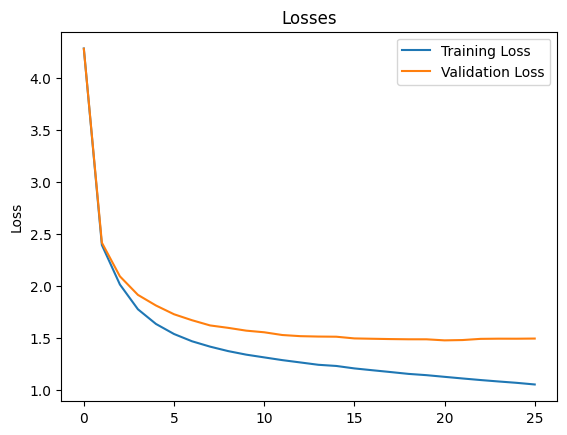


But with prison: I will steel with my fame?
For myself I'll reconceive without 'larganes' form,
Provoke itself a lewful manifies.
Affright the feelow me slaves of these weep,
Or most lords, lets her rebals to do me here
Tewlate the sun of Margary can see hence without
With not thine twenty, cousin, their bearing their
stephes; I am likers again.

ISABELLA:
As I was recelless lack to such, my lord,
I pray now. Dorset, leave it with pains in thine!
For Even bring you! and you writes must me go:
no
CPU times: user 1h 6min 26s, sys: 7min 6s, total: 1h 13min 32s
Wall time: 1h 13min 48s


In [ ]:
%%time
#| output: true
torch.manual_seed(TORCH_SEED)
class TransformerLanguageModel(nn.Module):
    def __init__(self, head_size:int, vocab_size:int=vocab_size, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 num_layers:int=num_layers, dropout:float=dropout, num_heads:int=num_heads): #UPDATED
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = head_size
        self.num_layers = num_layers #NEW
        self.dropout = dropout

        self.token_embedding_table = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)
        self.token_position_embedding_table = nn.Embedding(num_embeddings=self.context_length, embedding_dim=self.embedding_dim)

        self.transformer_blocks = nn.Sequential(*([
            TransformerBlock(embedding_dim=embedding_dim, num_heads=num_heads, context_length=context_length,
                             dropout=self.dropout) for _ in range(self.num_layers)]+[
            nn.LayerNorm(embedding_dim)
        ])) #UPDATED
        self.language_model_head_linear_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.vocab_size)

    def forward(self, idx, targets=None):
        #Both idx and targets are (B,T) Batch x Time array of integers
        B,T = idx.shape
        token_embeddings = self.token_embedding_table(idx) #(B,T,C) Batch, Time, Channel
        token_position_embeddings = self.token_position_embedding_table(torch.arange(T, device=device)) #(T,C)
        x = token_embeddings + token_position_embeddings
        x = self.transformer_blocks(x)
        logits = self.language_model_head_linear_layer(x) #(B,T,C) Where C is now token logits of size vocab_size

        if targets is not None:
            B,T,C = logits.shape
            logits_reshaped = logits.view(B*T,C)
            targets_reshaped = targets.view(B*T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss=None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        #idx is (B,T) array of indicies in the current context
        for _ in range(max_new_tokens):
            #Crop idx to the max size of our positional embeddings table
            idx_crop = idx[:,-self.context_length:]
            #Get predictions
            logits, loss = self(idx_crop)
            #Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:,-1,:] #Becomes (B,C)
            #Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1) #(B,C)
            #Sample from the probs distribution.
            idx_next = torch.multinomial(input=probs, num_samples=1) #(B,1) Returns (B,idxs) where idxs are random integer indicies.
            #Append the sampled indexes idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1) #(B, T+1)
        return idx

model = TransformerLanguageModel(head_size=head_size1, vocab_size=vocab_size, embedding_dim=embedding_dim, context_length=context_length)
model = model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
tracked_losses = list()
for step in range(max_iters):
    if step % eval_iters == 0 or step == max_iters-1:
        losses = estimate_loss()
        tracked_losses.append(losses)
        print('Step:',step,'Training Loss:',round(losses['train'].item(),3),'Validation Loss:',round(losses['valid'].item(),3))

    xb,yb = get_batch('train')
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

plot_losses(tracked_losses)
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context,max_new_tokens=500)[0].tolist()))

The results are starting to look pretty decent. The loss has dramatically improved. Scaling up the network has made a big difference. <br><br>
**Debugging Models Aside**: While trying to train the model I realized I had made a mistake in the code. I tried to train this several times but loss would not drop below about 2.4. I went back through my code and nothing obvious was standing out to me that was wrong. After an hour of scouring my code I finally found the issue. It was a subtle change, but made all the difference. This was my code before the fix: <br>
```python
weights = (q @ k.transpose(-2,-1)) / self.head_size**-0.5
```
and this was my code after:<br>
```python
weights = (q @ k.transpose(-2,-1)) * self.head_size**-0.5
```
When we first implemented dividing the `weights` by the head size to fix the issue with large numbers passing through softmax, I had been using the `.../math.sqrt(head_size)`. To try and make things more consistent with Andrej's code and to remove the requirement to `import math` I switched the implementation over to the way he was doing it which was taking the head_size to the power of 0.5 which is equivalent to the sqrt, but I had missed that it was a -0.5 which is equivalent to 1/sqrt(0.5) so instead of dividing by `self.head_size**-0.5` I should have been multiplying by it. This can be one of the big challenges in deep learning. Often times when you make a mistake, no error is thrown, it just doesn't work. Sometimes it affects the results by a little and other times it affects it by a lot which is what happened in my case. Thankfully I had benchmarks to compare my result against so it was clear that I had an implementation issue, not that the model I was using was incapable of getting better results.

# Conclusion

In this notebook we have built a transformer model based on the [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper following along with Andrej Karpathy's fantastic YouTube video: [Let's build GPT: from scratch, in code, spelled out](https://www.youtube.com/watch?v=kCc8FmEb1nY). While building out the transformer we tried to build an intuition on what makes the transformer work. I hope you found the format of this notebook useful, adding and modifying the code as we went, enabling you to follow along, run the code and see the output with each step.